### **Introducción**

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales.

**Objetivo**:   
Crear un modelo que determine la tasa de cancelación de clientes.

   
   


---

### **Pasos**    

Abordaremos el problema haciendo los siguientes pasos:

1. **Análisis exploratorio de datos**:  
   - Importar librerías necesarias
   - Descargar y leer los archivos que se nos dan. Entender su estructura y contenido.  
   - Limpieza de datos: identificar valores ausentes, duplicados, tipos de datos, outliers y columnas irrelevantes.  

2. **Unir tablas y hacer EDA**:
  - Análisis de cada variable (columna) del data frame junto.
      - Variables categóricas: hacer gráficos individuales de cada variable y empezar a obtener info útil
      - Hacer observaciones
      - Variables numéricas: hacer histogramas individuales de cada variable y empezar a obtener info útil
      - Hacer observaciones
  - Análisis univariado: relación entre variable predictora y variable a predecir.
      - Crear boxplots de mis variables numéricas y mi variable a predecir ("y"), encontrar rangos y crear nuevas columnas, analizarlos y hacer observaciones
      - Mismo paso que el pasado pero con mis variables categóricas
  - Análisis bivariado: pares de variables Vs variable a predecir
      - Hacer gráficos
  - Conclusiones
  
3. **División de datos**:
  - Dividir datos en entrenamiento, validación y prueba (60-20-20)
  - Hacer sub o sobre muestreo si es necesario en mi variable a predecir para un buen balanceo
  - Dependiendo si es necesario, codificar y escalar columnas (posiblemente eliminar columnas que no me ayuden)
  - Observaciones
  
4. **Crear modelos de clasificación binaria y hacer prueba final:**
  - Modelos de clasificación binaria: Árbol de decisión, Bosque aleatorio, Regresión logística, Descenso del gradiente.
  - Hacer prueba final con todos los modelos, comparar y ver el mejor modelo
  - Sacar métricas y gráficos de F1 y AUC-ROC mayor a .75
       
5. **Conclusiones finales**


---
### **1. Análisis exploratorio de datos**   

#### Pasos:
- A. Importar las librerías
- B. Leer los datos usando **`pd.read_csv`**.
- C. Usar **`.shape`, `info()`, `head()` y `describe()`** para analizar la estructura y contenido de los datos, arreglarlos si es necesario   
(en este caso poner "_" entre nombres de columnas y dejar en minúsculas)
- D. Cambiar tipos de datos con **`astype()`** en columnas que lo requieran. Checar valores ausentes con **`isna().sum()`**, rellenar valores con **`fillna()`** e identificar y eliminar duplicados con **`duplicated().sum()`** y **`drop_duplicates()`**.
  - D.1 Con **df_phone**
  - D.2 Con **df_personal**
  - D.3 Con **df_internet**
  - D.4 Con **df_contract**
- E. Visualizar la distribución de mis variable numéricas para checar posibles valores atípicos.

- F. Comparar data original Vs data limpiada

In [ ]:
#PASO A: Importar librerías
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import chi2_contingency

#Scikit-Learn Libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, roc_auc_score, roc_curve

In [ ]:
#PASO B: Leer los datos
from google.colab import drive

drive.mount('/content/drive')

folder_id = 'https://drive.google.com/drive/folders/1T7Wsyi3EWmNxIWpA2dcumvThWE7vbg_h?usp=drive_link'
folder_path = f'/content/drive/MyDrive/Colab Notebooks/Proyecto final'

# Verifica si la carpeta existe. Si no, intenta crearla.
if not os.path.exists(folder_path):
  print(f"La carpeta no existe. Verifique el ID: {folder_id}")
else:
  os.chdir(folder_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#PASO B: Directorio actual (Proyecto final)
data_dir = '.'

df_phone_og = pd.read_csv(os.path.join(data_dir, 'phone.csv'))
df_personal_og = pd.read_csv(os.path.join(data_dir, 'personal.csv'))
df_internet_og = pd.read_csv(os.path.join(data_dir, 'internet.csv'))
df_contract_og = pd.read_csv(os.path.join(data_dir, 'contract.csv'))

In [ ]:
#PASO C: Ver estructura de cada data frame y sus nombres en las columnas
print(f"Data en 'df_phone_og' {df_phone_og.shape}, Columnas: {df_phone_og.columns.values}")
print()
print(f"Data en 'df_personal_og' {df_personal_og.shape}, Columnas: {df_personal_og.columns.values}")
print()
print(f"Data en 'df_internet_og' {df_internet_og.shape}, Columnas: {df_internet_og.columns.values}")
print()
print(f"Data en 'df_contract_og' {df_contract_og.shape}, Columnas: {df_contract_og.columns.values}")


Data en 'df_phone_og' (6361, 2), Columnas: ['customerID' 'MultipleLines']

Data en 'df_personal_og' (7043, 5), Columnas: ['customerID' 'gender' 'SeniorCitizen' 'Partner' 'Dependents']

Data en 'df_internet_og' (5517, 8), Columnas: ['customerID' 'InternetService' 'OnlineSecurity' 'OnlineBackup'
 'DeviceProtection' 'TechSupport' 'StreamingTV' 'StreamingMovies']

Data en 'df_contract_og' (7043, 8), Columnas: ['customerID' 'BeginDate' 'EndDate' 'Type' 'PaperlessBilling'
 'PaymentMethod' 'MonthlyCharges' 'TotalCharges']


In [ ]:
#Definir función para estandarizar nombre de columnas en todos los dataframes a minúsculas y agregar "_"
def estandarizar_nombre_columna(nombre_columna):
    """
    Estandariza un nombre de columna: minúsculas, guiones bajos, elimina caracteres especiales.
    """
    nombre_columna = re.sub(r'[^a-zA-Z0-9]', '', nombre_columna)  # Eliminar caracteres especiales
    nombre_columna = re.sub(r'((?<=[a-z0-9])[A-Z]|(?!^)[A-Z](?=[a-z]))', r'_\1', nombre_columna)  # Insertar guiones bajos
    nombre_columna = nombre_columna.lower()  # Convertir a minúsculas

    return nombre_columna

In [ ]:
#Utilizar función
df_phone_og.columns = [estandarizar_nombre_columna(col) for col in df_phone_og.columns]
df_phone = df_phone_og.copy()

df_personal_og.columns = [estandarizar_nombre_columna(col) for col in df_personal_og.columns]
df_personal = df_personal_og.copy()

df_internet_og.columns = [estandarizar_nombre_columna(col) for col in df_internet_og.columns]
df_internet = df_internet_og.copy()

df_contract_og.columns = [estandarizar_nombre_columna(col) for col in df_contract_og.columns]
df_contract = df_contract_og.copy()

In [ ]:
#Ejemplo de resultado de la función
print(f"Data en 'df_phone' Columnas: {df_phone.columns.values}")

Data en 'df_phone' Columnas: ['customer_id' 'multiple_lines']


In [ ]:
#PASO D.1: Cambiar tipo de datos si es necesario en "df_phone"
display(df_phone.head(3))
print()
print(df_phone.info())
print()

#PASO D.1: Checar valores ausentes, rellenar valores y ver/eliminar duplicados
print(f"Valores ausentes en 'df_phone':")
print(df_phone.isna().sum())
print()
print(f"Datos duplicados en 'df_phone': {df_phone.duplicated().sum()}")


,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None

Valores ausentes en 'df_phone':
customer_id       0
multiple_lines    0
dtype: int64

Datos duplicados en 'df_phone': 0


In [ ]:
#PASO D.2: Cambiar tipo de datos si es necesario en "df_personal"
display(df_personal.head(3))
print()
print(df_personal.info())
print()

#PASO D.2: Checar valores ausentes, rellenar valores y ver/eliminar duplicados
print(f"Valores ausentes en 'df_personal':")
print(df_personal.isna().sum())
print()
print(f"Datos duplicados en 'df_phone': {df_personal.duplicated().sum()}")


,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None

Valores ausentes en 'df_personal':
customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64

Datos duplicados en 'df_phone': 0


In [ ]:
#PASO D.3: Cambiar tipo de datos si es necesario en "df_internet"
display(df_internet.head(3))
print()
print(df_internet.info())
print()

#PASO D.3: Checar valores ausentes, rellenar valores y ver/eliminar duplicados
print(f"Valores ausentes en 'df_personal':")
print(df_internet.isna().sum())
print()
print(f"Datos duplicados en 'df_internet': {df_internet.duplicated().sum()}")

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None

Valores ausentes en 'df_personal':
customer_id          0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64

Datos duplicados en 'df_internet': 0


In [ ]:
#PASO D.4: Cambiar tipo de datos si es necesario en "df_contract"
display(df_contract.head(3)) #Tener representación rica del data frame con display()
print()
print(df_contract.info())
print()

#Cambiar datos a flotantes y datetime
df_contract['total_charges'] = pd.to_numeric(df_contract['total_charges'], errors='coerce')

def convertir_fecha(fecha):
    """Convierte una fecha a datetime, manejando diferentes formatos."""
    if fecha == 'No':
        return pd.NaT  # Manejar el valor 'No' como NaT
    try:
        return pd.to_datetime(fecha, format='%Y-%m-%d')  # Intentar formato YYYY-MM-DD
    except ValueError:
        try:
            return pd.to_datetime(fecha, format='%Y-%m-%d %H:%M:%S')  # Intentar formato YYYY-MM-DD HH:MM:SS
        except ValueError:
            return pd.NaT  # Si falla ambos formatos, retornar NaT

df_contract['begin_date'] = df_contract['begin_date'].apply(convertir_fecha)
df_contract['end_date'] = df_contract['end_date'].apply(convertir_fecha)

#Comparar data frames con muestras reales en "end_date"
print(df_contract.info())
print()

#PASO D.4: Checar valores ausentes, rellenar valores y ver/eliminar duplicados
print(f"Valores ausentes en 'df_contract':")
print(df_contract.isna().sum())
print()
print(f"Datos duplicados en 'df_contract': {df_contract.duplicated().sum()}")



,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           186

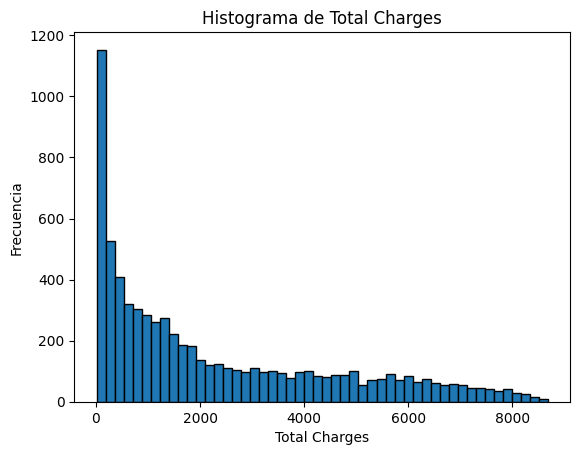

In [ ]:
#Histograma de datos de total_charges
plt.hist(df_contract['total_charges'], bins=50, edgecolor='black')
plt.xlabel('Total Charges')
plt.ylabel('Frecuencia')
plt.title('Histograma de Total Charges')
plt.show()



Ya que no cuenta con una distribución normal, usaremos mediana para rellenar valores ausentes

In [ ]:
#PASO D.4: Rellenar con "mediana" los valores ausentes en "total_charges"
df_contract['total_charges'] = df_contract['total_charges'].fillna(df_contract['total_charges'].median())
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


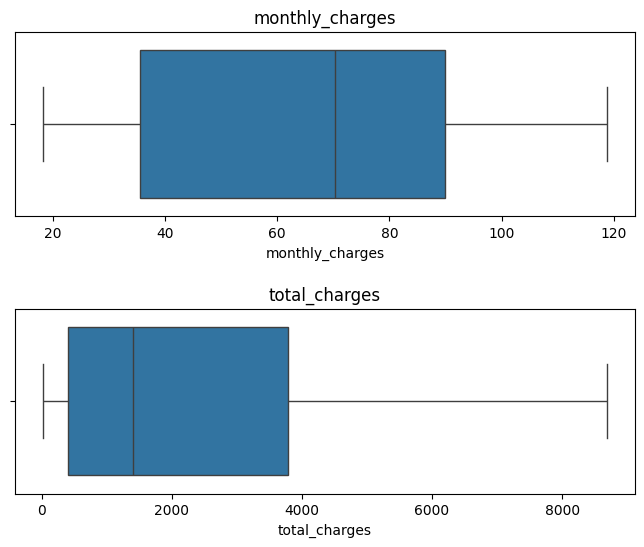

In [ ]:
#PASO E: Visualizar la distribución de mis variable numéricas para checar posibles valores atípicos.
col_num = df_contract.select_dtypes(include=["float64"])

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,6))
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(col_num):
    sns.boxplot(x=col, data=df_contract, ax=ax[i])
    ax[i].set_title(col)

#### Observaciones:
Solo en "total_charges" hay números garandes pero no los consideraría atípicos, si pueden repercutir en los números finales de mis modelos pero más adelante checaré si es necesario eliminar esos números o dejarlo tal cual.

In [ ]:
#PASO F: Comparación
print(f"Data en 'df_phone_og': {df_phone_og.shape} Vs 'df_phone': {df_phone.shape}")
print()
print(f"Data en 'df_personal_og' {df_personal_og.shape} Vs 'df_personal': {df_personal.shape}")
print()
print(f"Data en 'df_internet_og' {df_internet_og.shape} Vs 'df_internet': {df_internet.shape}")
print()
print(f"Data en 'df_contract_og' {df_contract_og.shape} Vs 'df_contract': {df_contract.shape}")


Data en 'df_phone_og': (6361, 2) Vs 'df_phone': (6361, 2)

Data en 'df_personal_og' (7043, 5) Vs 'df_personal': (7043, 5)

Data en 'df_internet_og' (5517, 8) Vs 'df_internet': (5517, 8)

Data en 'df_contract_og' (7043, 8) Vs 'df_contract': (7043, 8)


Observaciones:
No hubo cambio en los "size" de cada data frame

---
### **2. Unir tablas y hacer EDA**   

#### **Pasos:**
  - A. Unir las tablas para tener un solo data frame con **`merge()`**    
      - Creamos nuevas variables gracias a las fechas
  - B. Análisis de cada variable (columna) del data frame junto.
      - Variables categóricas: hacer gráficos individuales de cada variable y empezar a obtener info útil
      - Hacer observaciones
      - Variables numéricas: hacer histogramas individuales de cada variable y empezar a obtener info útil
      - Hacer observaciones
  - C. Análisis univariado: relación entre variable predictora y variable a predecir.
      - Crear boxplots de mis variables numéricas y mi variable a predecir ("y"), encontrar rangos y crear nuevas columnas, analizarlos y hacer observaciones
      - Tasas de conversión con mis variables
      - Gráficos para variables categóricas
      - Crear nuevas variables
      - Resúmen
      - Eliminar variables
  - D. Análisis bivariado: pares de variables Vs variable a predecir
      - Hacer gráficos
      - Resúmen
  - E. Conclusiones

#### **A.- Unir las tablas para tener un solo data frame con `merge()`**

In [ ]:
#PASO 1: Unir tablas con merge()
df_combined = pd.merge(df_phone, df_personal, on='customer_id', how="outer")
df_combined = pd.merge(df_combined, df_internet, on='customer_id', how="outer")
df_combined = pd.merge(df_combined, df_contract, on='customer_id', how="outer")
display(df_combined.head())
print(df_combined.shape)

,customer_id,multiple_lines,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,0002-ORFBO,No,Female,0,Yes,Yes,DSL,No,Yes,No,Yes,Yes,No,2019-05-01,NaT,One year,Yes,Mailed check,65.6,593.30
1,0003-MKNFE,Yes,Male,0,No,No,DSL,No,No,No,No,No,Yes,2019-05-01,NaT,Month-to-month,No,Mailed check,59.9,542.40
2,0004-TLHLJ,No,Male,0,No,No,Fiber optic,No,No,Yes,No,No,No,2019-09-01,2020-01-01,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,No,Male,1,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,2018-12-01,2020-01-01,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,No,Female,1,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,2019-09-01,2019-12-01,Month-to-month,Yes,Mailed check,83.9,267.40


(7043, 20)


**Observaciones:**   
El hecho de que se unieran sin que se sumaran nuevas filas al data frame con mayor cantidad de valores ("contract") nos explica que todos los clientes en los df de "phone", "internet" y "personal" se encontraban dentro del df de "contract", esto significa que hay clientes que tienen todos los servicios o algunos contratados.

In [ ]:
#Analizamos nueva tabla combinada
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   multiple_lines     6361 non-null   object        
 2   gender             7043 non-null   object        
 3   senior_citizen     7043 non-null   int64         
 4   partner            7043 non-null   object        
 5   dependents         7043 non-null   object        
 6   internet_service   5517 non-null   object        
 7   online_security    5517 non-null   object        
 8   online_backup      5517 non-null   object        
 9   device_protection  5517 non-null   object        
 10  tech_support       5517 non-null   object        
 11  streaming_tv       5517 non-null   object        
 12  streaming_movies   5517 non-null   object        
 13  begin_date         7043 non-null   datetime64[ns]
 14  end_date

In [ ]:
#Creamos nuevas variables con ayuda de las variables de fecha (año, mes y día de la semana, día no es relevante ya que es el mismo siempre)
df_combined['begin_year'] = df_combined['begin_date'].dt.year
df_combined['begin_month'] = df_combined['begin_date'].dt.month
df_combined['begin_weekday'] = df_combined['begin_date'].dt.dayofweek # 0 = lunes, 6 = domingo

df_combined['end_year'] = df_combined['end_date'].dt.year
df_combined['end_month'] = df_combined['end_date'].dt.month
df_combined['end_weekday'] = df_combined['end_date'].dt.dayofweek # 0 = lunes, 6 = domingo

#Variable sobre duración del servicio
df_combined['duration_service'] = (df_combined['end_date'] - df_combined['begin_date']).dt.days

# Ahora eliminámos la columna original 'begin_date' sigo manteniendo "end_date"
df_combined = df_combined.drop('begin_date', axis=1)

#### **B.- Análisis de cada variable (columna) del data frame junto.**

##### **Variables categóricas**

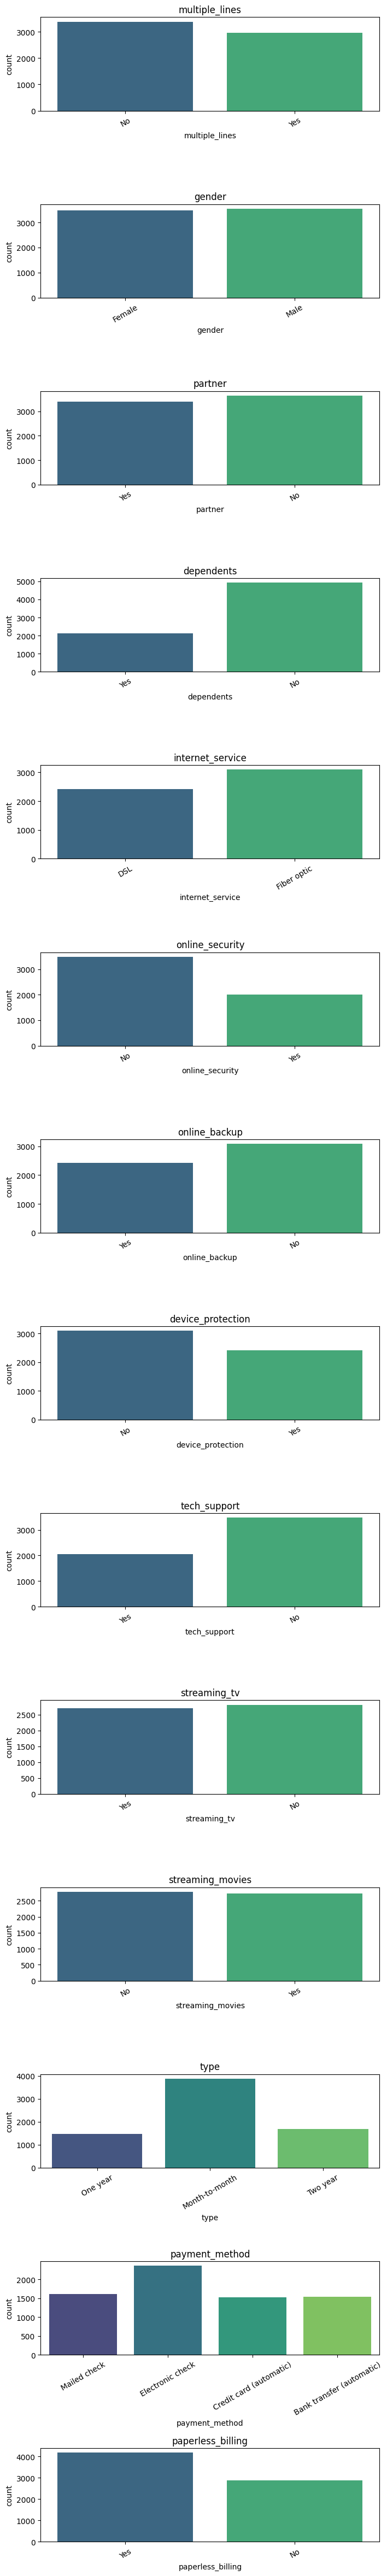

In [ ]:
#Tomemos las variables categóricas y generemos gráficos de barras
col_cat = ['multiple_lines', 'gender', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'type', 'payment_method', 'paperless_billing']

#Gráficos de barras por columna
fig, ax = plt.subplots(nrows=len(col_cat), ncols=1, figsize=(8,60))
fig.subplots_adjust(hspace=1)

for i, col in enumerate(col_cat):
    sns.countplot(x=col, data=df_combined, ax=ax[i], hue=col, legend=False, palette='viridis')
    ax[i].set_title(col)
    plt.sca(ax[i])
    plt.xticks(rotation=30)

###### **-Observaciones de variables categóricas**:
Niveles en cada variable
  - **multiple_lines:** 2 (yes, no) balanceados
  - **gender:** 2 (male, female) balanceados
  - **partner:** 2 (yes, no) balanceados
  - **dependets:** 2 (yes, no) Gran mayoría no depende de alguien más
  - **internet_service:** 2 (dsl, fiber optic) balanceados
  - **online_security:** 2 (yes, no) hay más gente que no cuenta con el servicio
  - **online_backup:** 2 (yes, no) balanceados
  - **device_protection:** 2 (yes, no) balanceados
  - **tech_support:** 2 (yes, no) más gente no cuenta con el servicio
  - **streaming_tv:** 2 (yes, no) balanceados
  - **streaming_movies:** 2 (yes, no) balanceados
  - **type:** 3 (un año, dos años, mensual) la gran mayoría elige pago mensual, los otros años se quedan igual
  - **payment_method:** 4 (correo, pago electrónico, tarjeta, transferencia) mayoría opta por pago electrónico, los demás se quedan igual
  - **paperless_billing:** 2 (yes, no) optan por no mucho la opción de facturación sin papel

---
##### **Variables numéricas**

In [ ]:
#Tomemos las variables numéricas, usemos describe() y generemos histogramas
df_combined.describe()

,senior_citizen,end_date,monthly_charges,total_charges,begin_year,begin_month,begin_weekday,end_year,end_month,end_weekday,duration_service
count,7043.000000,1869,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,1869.000000,1869.000000,1869.000000,1869.000000
mean,0.162147,2019-11-15 21:31:18.009630976,64.761692,2281.916928,2016.878603,6.421269,3.209428,2019.246121,8.543071,3.271268,547.352060
min,0.000000,2019-10-01 00:00:00,18.250000,18.800000,2013.000000,1.000000,0.000000,2019.000000,1.000000,1.000000,30.000000
25%,0.000000,2019-11-01 00:00:00,35.500000,402.225000,2015.000000,3.000000,1.000000,2019.000000,10.000000,2.000000,61.000000
50%,0.000000,2019-11-01 00:00:00,70.350000,1397.475000,2017.000000,6.000000,3.000000,2019.000000,11.000000,4.000000,304.000000
75%,0.000000,2019-12-01 00:00:00,89.850000,3786.600000,2019.000000,10.000000,5.000000,2019.000000,11.000000,4.000000,883.000000
max,1.000000,2020-01-01 00:00:00,118.750000,8684.800000,2020.000000,12.000000,6.000000,2020.000000,12.000000,6.000000,2191.000000
std,0.368612,NaN,30.090047,2265.270398,1.970573,3.578453,1.997872,0.430865,4.368087,1.912635,594.389607


In [ ]:
#Cambiar variables "end_..." y begin_... a tipo de dato "int64" y rellenar valores faltantes
df_combined["end_year"] = df_combined["end_year"].fillna(0).astype("int64")
df_combined["end_month"] = df_combined["end_month"].fillna(0).astype("int64")
df_combined["end_weekday"] = df_combined["end_weekday"].fillna(0).astype("int64")

df_combined["begin_year"] = df_combined["begin_year"].astype("int64")
df_combined["begin_month"] = df_combined["begin_month"].astype("int64")
df_combined["begin_weekday"] = df_combined["begin_weekday"].astype("int64")

df_combined["duration_service"] = df_combined["duration_service"].fillna(0).astype("int64")

#Rellenar valores faltantes de las variables que faltan
df_combined["multiple_lines"] = df_combined["multiple_lines"].fillna("NA")
df_combined["internet_service"] = df_combined["internet_service"].fillna("NA")
df_combined["online_security"] = df_combined["online_security"].fillna("NA")
df_combined["online_backup"] = df_combined["online_backup"].fillna("NA")
df_combined["device_protection"] = df_combined["device_protection"].fillna("NA")
df_combined["tech_support"] = df_combined["tech_support"].fillna("NA")
df_combined["streaming_tv"] = df_combined["streaming_tv"].fillna("NA")
df_combined["streaming_movies"] = df_combined["streaming_movies"].fillna("NA")



In [ ]:
#Muestra de datos para verificar que todos tengan la misma cantidad (excepto "end_date" mi variable a predecir)
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   multiple_lines     7043 non-null   object        
 2   gender             7043 non-null   object        
 3   senior_citizen     7043 non-null   int64         
 4   partner            7043 non-null   object        
 5   dependents         7043 non-null   object        
 6   internet_service   7043 non-null   object        
 7   online_security    7043 non-null   object        
 8   online_backup      7043 non-null   object        
 9   device_protection  7043 non-null   object        
 10  tech_support       7043 non-null   object        
 11  streaming_tv       7043 non-null   object        
 12  streaming_movies   7043 non-null   object        
 13  end_date           1869 non-null   datetime64[ns]
 14  type    

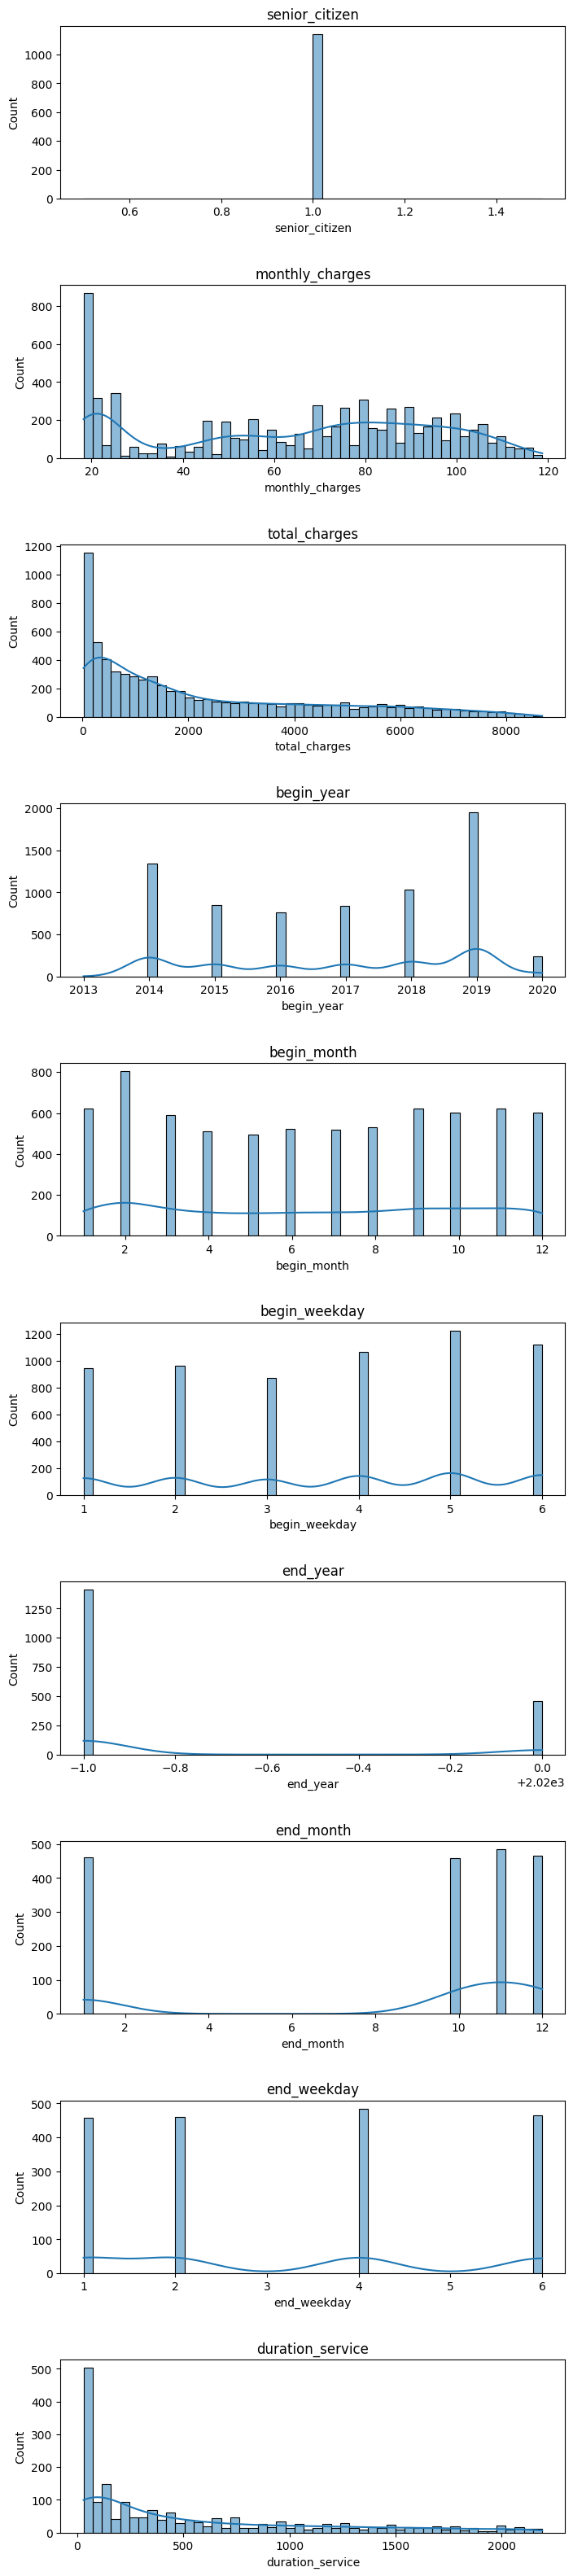

In [ ]:
#Histogramas en variables numéricas
col_num = df_combined.select_dtypes(include=[np.number]).columns.tolist()

fig, ax = plt.subplots(nrows=len(col_num), ncols=1, figsize=(8,40))
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(col_num):
    #Filtrar los datos para excluir los ceros
    data_to_plot = df_combined[df_combined[col] != 0][col]

    sns.histplot(x=data_to_plot, ax=ax[i], bins=50, kde=True)
    ax[i].set_title(col)
plt.show()

In [ ]:
#Creo otra variable llamada "cancelled" para cambiar el tipo de resultado de "end_date" la cual será mi nueva variable a predecir
df_combined['cancelled'] = df_combined['end_date'].apply(lambda x: 'activo' if pd.isna(x) else 'cancelo')

# Verificar el resultado
print(df_combined[['end_date', 'cancelled']].head())

    end_date cancelled
0        NaT    activo
1        NaT    activo
2 2020-01-01   cancelo
3 2020-01-01   cancelo
4 2019-12-01   cancelo


In [ ]:
# Representamos la variable a predecir ("cancelled") de forma binaria: 'activo' = 1, cancelo' = 0
diccionario = {'activo':1, 'cancelo':0}
binario = df_combined['cancelled'].map(diccionario)
df_combined['cancelled_bin'] = binario

#Eliminar variable de "cancelled" y "end_date" ya que se volvieron irrelevantes
df_combined.drop(['cancelled', "end_date"], axis=1, inplace=True)

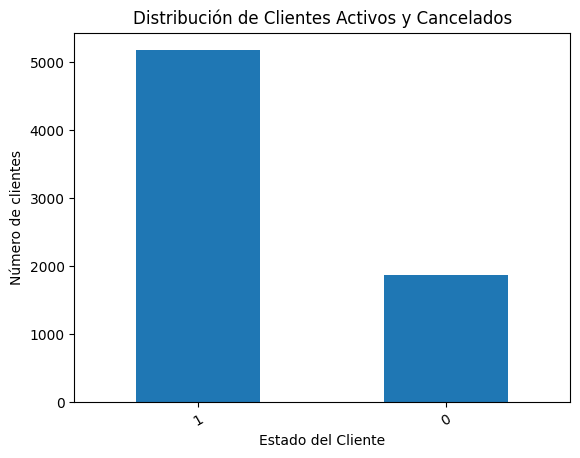

In [ ]:
#Vemos distribución de la variable
df_combined['cancelled_bin'].value_counts().plot.bar(rot=30)
plt.title('Distribución de Clientes Activos y Cancelados')
plt.xlabel('Estado del Cliente')
plt.ylabel('Número de clientes')
plt.show()

###### **-Observaciones variables numéricas**
Niveles en cada variable
  - **senior_citizen:** 2 (yes, no) gran mayoría no son "senior"
  - **monthly_charges:** La gran mayoría tiene un cargo mensual de 20 dolares.
  - **total_charges:** La gran mayoría tiene cargo total de 20 dolares
  - **begin_year:** Picos superiores en 2019 y luego en 2014
  - **begin_month:** Febrero suele ser el mes principal
  - **begin_weekday:** Los mejores días donde la gente suele iniciar su servicio es de viernes a domingo
  - **end_year:** todos para el 2019 y 2020
  - **end_month:** Datos para octubre. noviembre, diciembre y enero
  - **end_weekday:** Cancelaban en martes, miércoles, jueves y domingo
  - **duration_service:** La gran mayoría de gente que canceló solía estar de uno a dos meses

Creamos nueva variable con base en "end_date" **ya que será nuestra variable a predecir.** Podemos ver un claro desbalanceo de clases.
  - **cancelled_bin:** 2(activo, cancelado) la gran mayoría de los clientes están activos

#### **C-. Análisis univariado: relación entre variable predictora y variable a predecir.**

##### **Crear boxplots de mis variables numéricas**

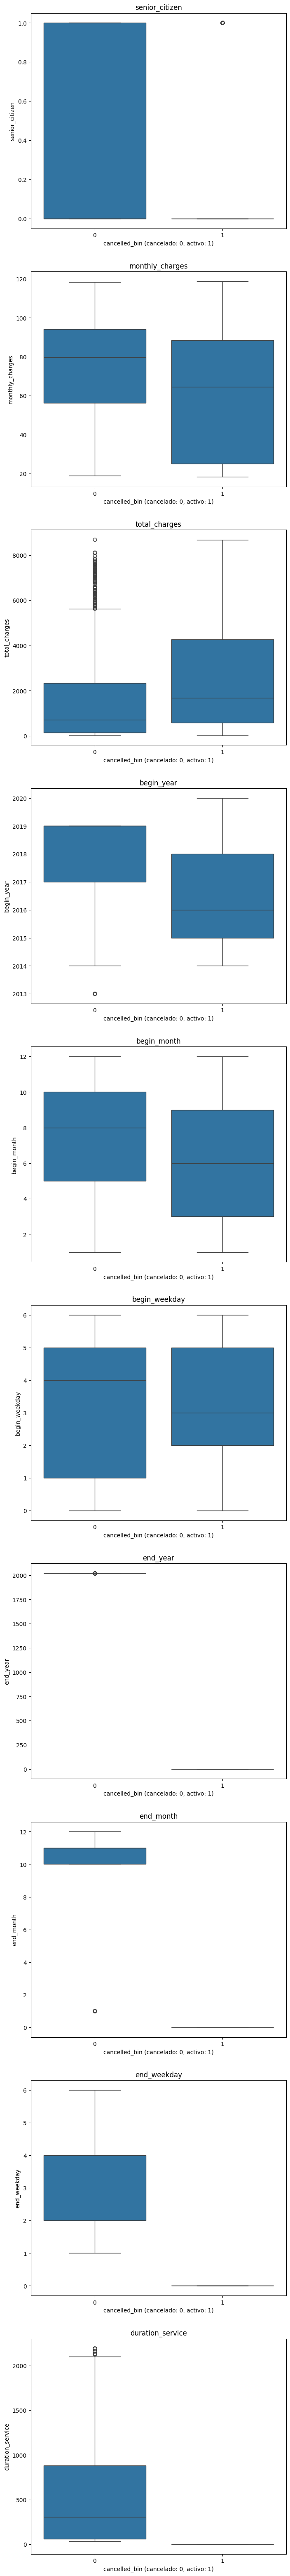

In [ ]:
#Análisis univariado, analizar la relación entre las variables numéricas y la variable a predecir ('cancelled_bin')

fig, ax = plt.subplots(nrows=10, ncols=1, figsize=(8,80))

for i, col in enumerate(col_num):
  bplt = sns.boxplot(x="cancelled_bin", y=col, data=df_combined, ax=ax[i])
  ax[i].set_xlabel('cancelled_bin (cancelado: 0, activo: 1)')
  ax[i].set_title(col)

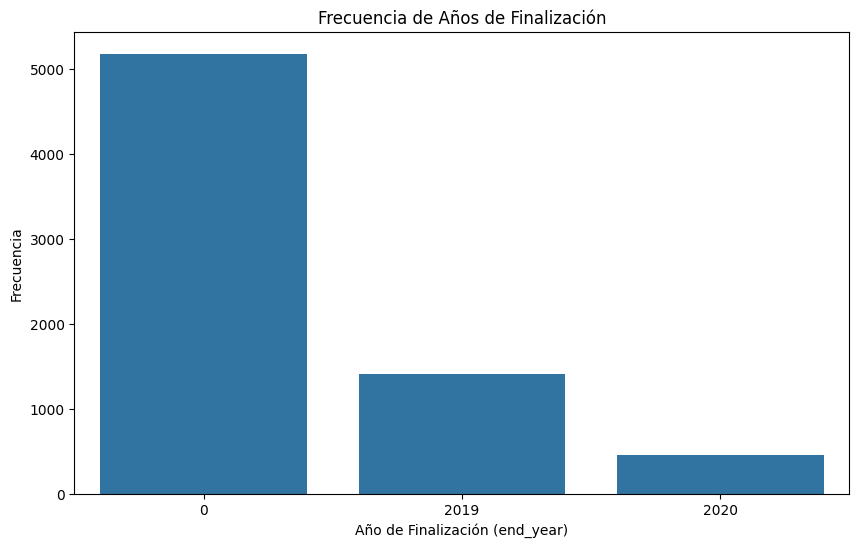

In [ ]:
#Contar la frecuencia de cada año
year_counts = df_combined["end_year"].value_counts().sort_index()

#Crear el gráfico de barras usando Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=year_counts.index, y=year_counts.values)
plt.xlabel("Año de Finalización (end_year)")
plt.ylabel("Frecuencia")
plt.title("Frecuencia de Años de Finalización")
plt.show()

In [ ]:
df_combined["end_year"].value_counts()

,count
end_year,
0,5174
2019,1409
2020,460


###### **-Observaciones univariadas de variables numéricas**

Podemos ver que para **"senior_citizen"** la gente mayor es más leal a la empresa y continua con ella, para los que cancelan tenemos de ambos (senior y no senior)

Conforme a **"monthly_charges"** podemos ver que aquellos que tienen cargos medios-altos, aprox entre 60 y 95 dolares, son mas propensos a cancelar.

Sobre **"total_charges"**, los cargos totales bajos están asociados con una mayor probabilidad de cancelación, lo que podría indicar que los clientes que cancelan lo hacen relativamente pronto en su contrato, mientras que los activos, al tener cargos más altos, podría notarse cierta lealtad por antiguedad y que contratan un mayor número de servicios. Pero no debemos descartar los valores atípicos en la cancelación, lo cual me indica, mayores cargos igual a cancelación.

Para **begin_year** vemos que los que han cancelado llegaron entre 2017 y 2019, para **begin_month** fue entre mayo y octubre, para **begin_weekday** de martes a sábado.

Para **end_year** vemos que los que cancelaron fue en 2019 y 2020, para **end_month** fue en octubre - noviembre, para **end_weekday** de míercoles a jueves.

Por último, **duration_service** muestra que aquellos que cancelaron estuvieron entre 30 a 900 días con el servicio. La media fue de 1.5 años de contrato


---
##### **Tasa de conversión**
Podemos calcular las tasas de conversión definiendo intervalos para estas variables numéricas y ver si podemos extraer información relevante de ese análisis

**No sé realiza con mis variables sacadas de end_date ya que se daría una relación circular con la variable a predecir**

In [ ]:
#Función para graficar tasas de conversión
def graficar_tasas_conversion(var_predictora, var_predecir, type='line', order=None):
    x, y = var_predictora, var_predecir

    #Generar agrupaciones (groupby), calcular tasa de conversión (mean), multiplicarla por 100 (mul(100))
    grupo = df_combined.groupby(x)[y].mean().mul(100).rename('tasa_conv').reset_index()

    #Y generar gráfica
    if type=='line': # Útil para rangos continuos
        plt.figure(figsize=(10,6))
        sns.lineplot(x=var_predictora, y='tasa_conv', data=grupo)
        plt.grid()
    elif type=='bar': # Útil si los datos están divididos en rangos o son categóricos
        plt.figure(figsize=(14,6))
        sns.barplot(x=var_predictora, y='tasa_conv', data=grupo, order=order)
        plt.grid()
    elif type=='scatter': # Útil si los datos están divididos en rangos o son categóricos
        plt.figure(figsize=(10,6))
        sns.scatterplot(x=var_predictora, y='tasa_conv', data=grupo)
        plt.grid()

##### **Crear gráficos de barras de mis variables categóricas**

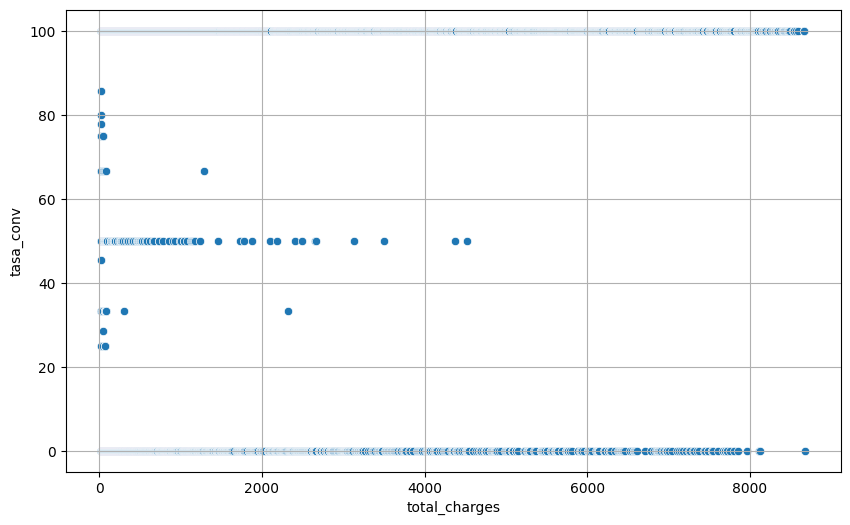

In [ ]:
#Graficar las tasas de conversión para la variable "total_charges"
graficar_tasas_conversion('total_charges','cancelled_bin', type="scatter")

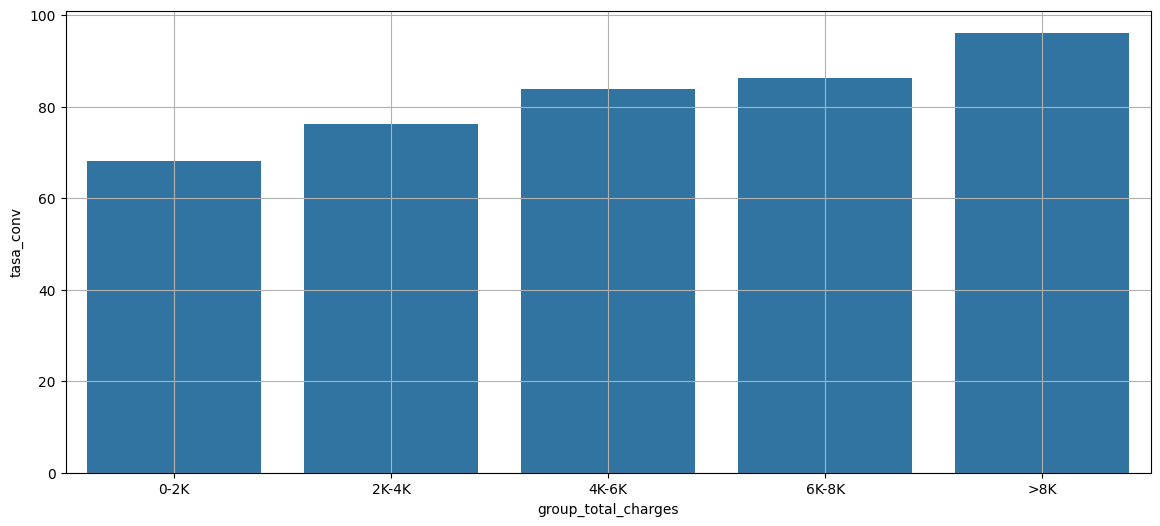

In [ ]:
#Ya que no se encuentra facilmente un patrón, generamos rangos.
#Nueva columna en el dataset: "group_total_charges"
df_combined.loc[:,'group_total_charges'] = "0"
df_combined.loc[(df_combined['total_charges']>0) & (df_combined['total_charges']<2000),'group_total_charges'] = "0-2K"
df_combined.loc[(df_combined['total_charges']>=2000) & (df_combined['total_charges']<4000),'group_total_charges'] = "2K-4K"
df_combined.loc[(df_combined['total_charges']>=4000) & (df_combined['total_charges']<6000),'group_total_charges'] = "4K-6K"
df_combined.loc[(df_combined['total_charges']>=6000) & (df_combined['total_charges']<8000),'group_total_charges'] = "6K-8K"
df_combined.loc[df_combined['total_charges']>=8000, "group_total_charges"] = ">8K"

#Y grafiquemos la tasa de conversión para esta nueva columna
orden = [ '0-2K', '2K-4K', '4K-6K', '6K-8K', '>8K']
graficar_tasas_conversion('group_total_charges','cancelled_bin',type='bar', order=orden)



In [ ]:
#Analizamos cantidades en cada rango
df_combined["group_total_charges"].value_counts()


,count
group_total_charges,
0-2K,4187
2K-4K,1208
4K-6K,956
6K-8K,614
>8K,78


In [ ]:
#Sacamos chi_cuadrado para ver si existe asociación relevante
def prueba_chi_cuadrado(df, columna1, columna2):
    """
    Realiza la prueba Chi-cuadrado para evaluar la asociación entre dos variables categóricas.

    Parámetros:
    df (pd.DataFrame): DataFrame que contiene las variables.
    columna1 (str): Nombre de la primera columna categórica.
    columna2 (str): Nombre de la segunda columna categórica.
    """

    #1. Crear la tabla de contingencia
    tabla_contingencia = pd.crosstab(df[columna1], df[columna2])

    #2. Realizar la prueba Chi-cuadrado
    chi2, p, grados_libertad, esperado = chi2_contingency(tabla_contingencia)

    #3. Interpretar los resultados
    print(f"Estadístico Chi-cuadrado: {chi2}")
    print(f"Valor p: {p}")
    print(f"Grados de libertad: {grados_libertad}")
    print("Frecuencias esperadas:\n", esperado)

    #Decisión basada en el valor p
    if p < 0.05:
        print(f"Existe una asociación estadísticamente significativa entre {columna1} y {columna2}.")
    else:
        print(f"No existe una asociación estadísticamente significativa entre {columna1} y {columna2}.")

In [ ]:
 prueba_chi_cuadrado(df_combined, "group_total_charges", "cancelled_bin")

Estadístico Chi-cuadrado: 192.02270414200078
Valor p: 1.948148924168977e-40
Grados de libertad: 4
Frecuencias esperadas:
 [[1111.10364901 3075.89635099]
 [ 320.56680392  887.43319608]
 [ 253.69359648  702.30640352]
 [ 162.93710067  451.06289933]
 [  20.69884992   57.30115008]]
Existe una asociación estadísticamente significativa entre group_total_charges y cancelled_bin.


###### **Obs: group_total_charges**

Este gráfico nos enseña a primera vista que hay que poner más atención en los clientes con mayores cargos **(Outliers)** ya que tienen el mayor número de probabilidad de irse, pero si también hacemos la comparación de cantidad de clientes en cada rango, podemos ver que sería mejor darle **prioridad a la gente con cargos de 0 a 2k** ya que son 50 veces más que los clientes en 8k.

No hago gran caso a los valores de "0", ya que son muy pocos.   

**group_total_charges es una variable predictora**

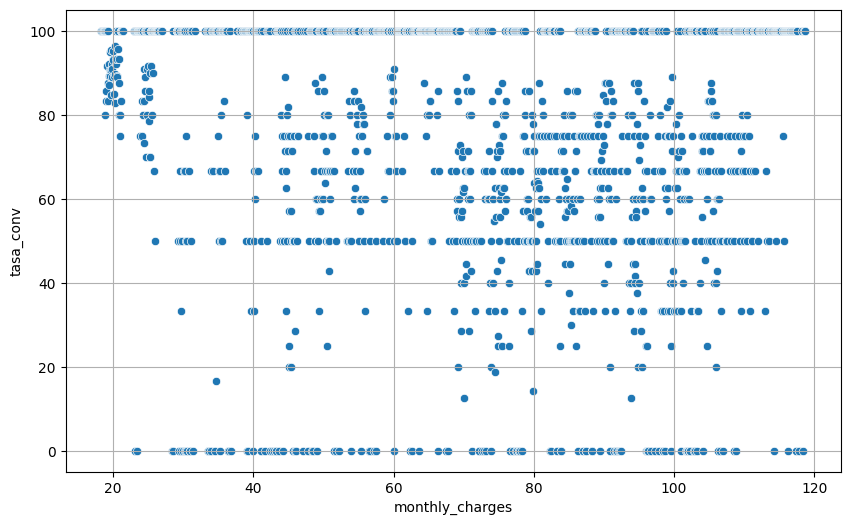

In [ ]:
#PASO 3: Graficar las tasas de conversión para la variable "monthly_charges"
graficar_tasas_conversion('monthly_charges','cancelled_bin', type="scatter")

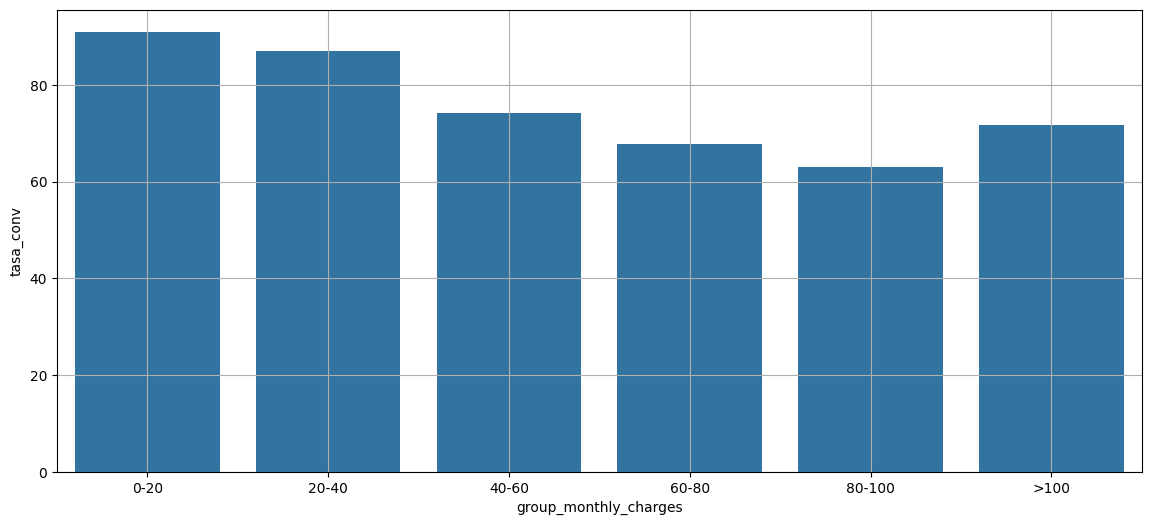

In [ ]:
#Ya que no se encuentra facilmente un patrón, generamos rangos.
#Nueva columna en el dataset: "group_monthly_charges"
df_combined.loc[:,'group_monthly_charges'] = "0"
df_combined.loc[(df_combined['monthly_charges']>0) & (df_combined['monthly_charges']<20),'group_monthly_charges'] = "0-20"
df_combined.loc[(df_combined['monthly_charges']>=20) & (df_combined['monthly_charges']<40),'group_monthly_charges'] = "20-40"
df_combined.loc[(df_combined['monthly_charges']>=40) & (df_combined['monthly_charges']<60),'group_monthly_charges'] = "40-60"
df_combined.loc[(df_combined['monthly_charges']>=60) & (df_combined['monthly_charges']<80),'group_monthly_charges'] = "60-80"
df_combined.loc[(df_combined['monthly_charges']>=80) & (df_combined['monthly_charges']<100),'group_monthly_charges'] = "80-100"
df_combined.loc[df_combined['monthly_charges']>=100, "group_monthly_charges"] = ">100"

# Y grafiquemos la tasa de conversión para esta nueva columna
orden = ["0-20", "20-40", "40-60", "60-80", "80-100", ">100"]
graficar_tasas_conversion('group_monthly_charges','cancelled_bin',type='bar', order=orden)


In [ ]:
#Analizamos cantidades de cada rango
df_combined["group_monthly_charges"].value_counts().sort_index()

,count
group_monthly_charges,
0-20,613
20-40,1224
40-60,1070
60-80,1459
80-100,1769
>100,908


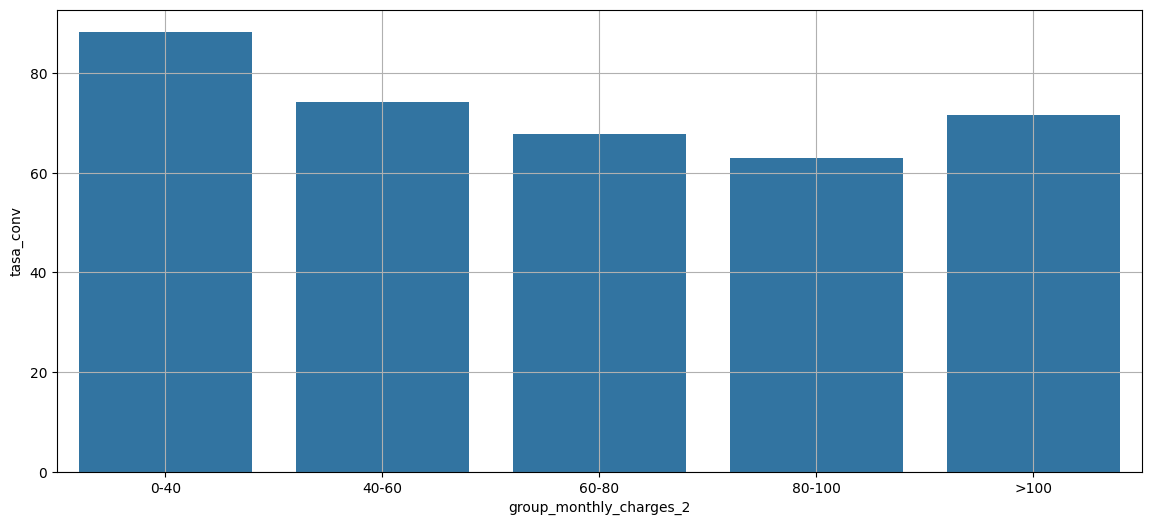

In [ ]:
#Reagrupamos nuevamente, nueva columna en el dataset: "group_monthly_charges_2"
df_combined.loc[:,'group_monthly_charges_2'] = "0"
df_combined.loc[(df_combined['monthly_charges']>0) & (df_combined['monthly_charges']<40),'group_monthly_charges_2'] = "0-40"
df_combined.loc[(df_combined['monthly_charges']>=40) & (df_combined['monthly_charges']<60),'group_monthly_charges_2'] = "40-60"
df_combined.loc[(df_combined['monthly_charges']>=60) & (df_combined['monthly_charges']<80),'group_monthly_charges_2'] = "60-80"
df_combined.loc[(df_combined['monthly_charges']>=80) & (df_combined['monthly_charges']<100),'group_monthly_charges_2'] = "80-100"
df_combined.loc[df_combined['monthly_charges']>=100, "group_monthly_charges_2"] = ">100"

# Y grafiquemos la tasa de conversión para esta nueva columna
orden = ["0-40", "40-60", "60-80", "80-100",">100"]
graficar_tasas_conversion('group_monthly_charges_2','cancelled_bin',type='bar', order=orden)

#Elimino variable original 'group_monthly_charges'
df_combined.drop(['group_monthly_charges'], axis=1, inplace=True)

In [ ]:
#Analizamos nuevamente cantidades
df_combined["group_monthly_charges_2"].value_counts().sort_index()

,count
group_monthly_charges_2,
0-40,1837
40-60,1070
60-80,1459
80-100,1769
>100,908


In [ ]:
 #Hacemos prueba chi
 prueba_chi_cuadrado(df_combined, "group_monthly_charges_2", "cancelled_bin")

Estadístico Chi-cuadrado: 333.9599151908376
Valor p: 5.090767878588307e-71
Grados de libertad: 4
Frecuencias esperadas:
 [[ 487.48445265 1349.51554735]
 [ 283.94576175  786.05423825]
 [ 387.17464149 1071.82535851]
 [ 469.43930143 1299.56069857]
 [ 240.95584268  667.04415732]]
Existe una asociación estadísticamente significativa entre group_monthly_charges_2 y cancelled_bin.


###### **Obs: group_monthly_charges_2**

Podemos ver para monthly_charges algo parecido que con total_charges, habrá que ver **más de cerca a los clientes con cargos entre 0-40 dólares** ya que son los más propensos a cancelar, pero tanto **40-60 como >100 no se quedan muy atrás** y la cantidad de gente que tienen es mucho mayor a 0-40, lo cual también sería un dato importante ha considerar.

**group_monthly_charges es una variable predictora**

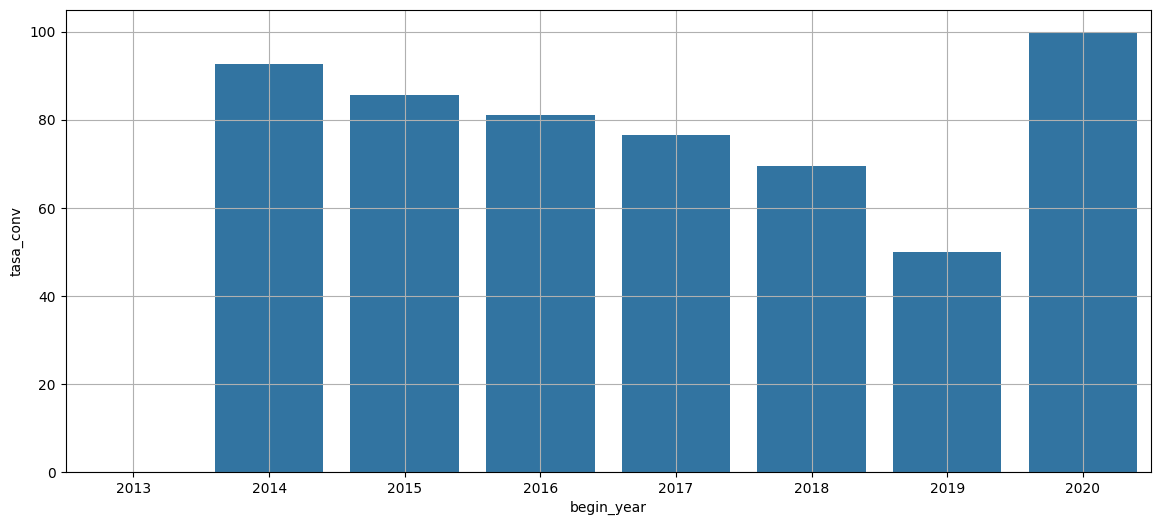

In [ ]:
#PASO 3: Graficar las tasas de conversión para la variable "begin_year"
graficar_tasas_conversion('begin_year','cancelled_bin', type="bar")

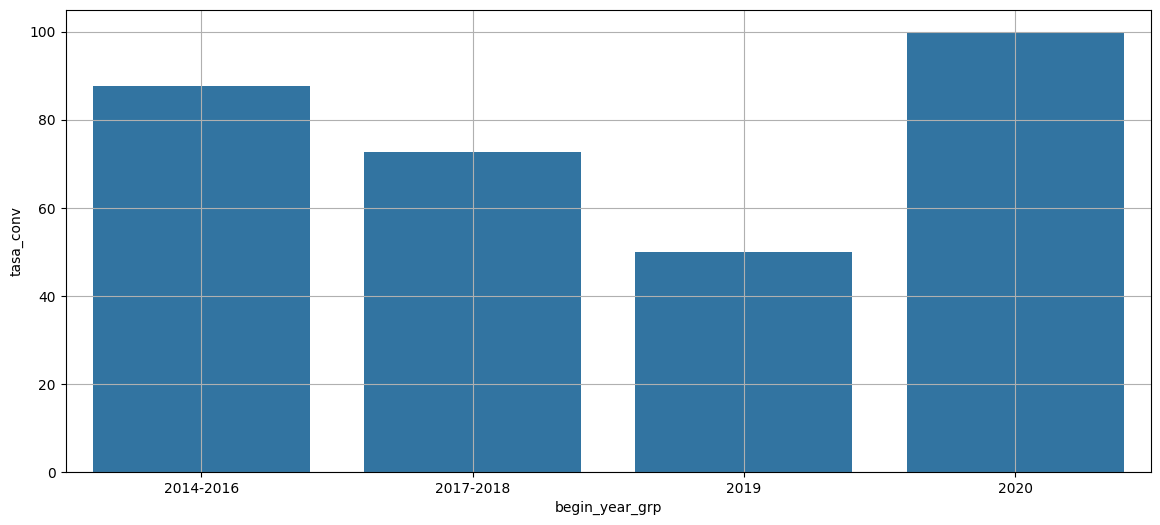

In [ ]:
#Generamos rangos.
df_combined.loc[:,'begin_year_grp'] = "0"
df_combined.loc[(df_combined['begin_year']>=2014) & (df_combined['begin_year']<=2016),'begin_year_grp'] = "2014-2016"
df_combined.loc[(df_combined['begin_year']>=2017) & (df_combined['begin_year']<=2018),'begin_year_grp'] = "2017-2018"
df_combined.loc[(df_combined['begin_year']==2019),'begin_year_grp'] = "2019"
df_combined.loc[(df_combined['begin_year']==2020),'begin_year_grp'] = "2020"

# Y grafiquemos la tasa de conversión para esta nueva columna
orden = [ "2014-2016", "2017-2018", "2019", "2020"]
graficar_tasas_conversion('begin_year_grp','cancelled_bin',type='bar', order=orden)

#Eliminamos variable original "begin_year"
df_combined.drop('begin_year', axis=1, inplace=True)


In [ ]:
#Analizamos cantidades de cada rango
df_combined["begin_year_grp"].value_counts().sort_index()

,count
begin_year_grp,
0,8
2014-2016,2959
2017-2018,1875
2019,1957
2020,244


In [ ]:
#Hacemos prueba chi
prueba_chi_cuadrado(df_combined, "begin_year_grp", "cancelled_bin")

Estadístico Chi-cuadrado: 974.3698503195334
Valor p: 1.278968066919221e-209
Grados de libertad: 4
Frecuencias esperadas:
 [[2.12295897e+00 5.87704103e+00]
 [7.85229448e+02 2.17377055e+03]
 [4.97568508e+02 1.37743149e+03]
 [5.19328837e+02 1.43767116e+03]
 [6.47502485e+01 1.79249752e+02]]
Existe una asociación estadísticamente significativa entre begin_year_grp y cancelled_bin.


###### **Obs: begin_year_grp**

Existe una tendencia ya que vemos que 2020 tiene una tasa del 100%, habrá que tomar en cuenta eso y los años de 2014-2016 ya que cuentan con gran cantidad de clientes y una tasa bastante alta, **begin_year_grp** es una **variable predictora**

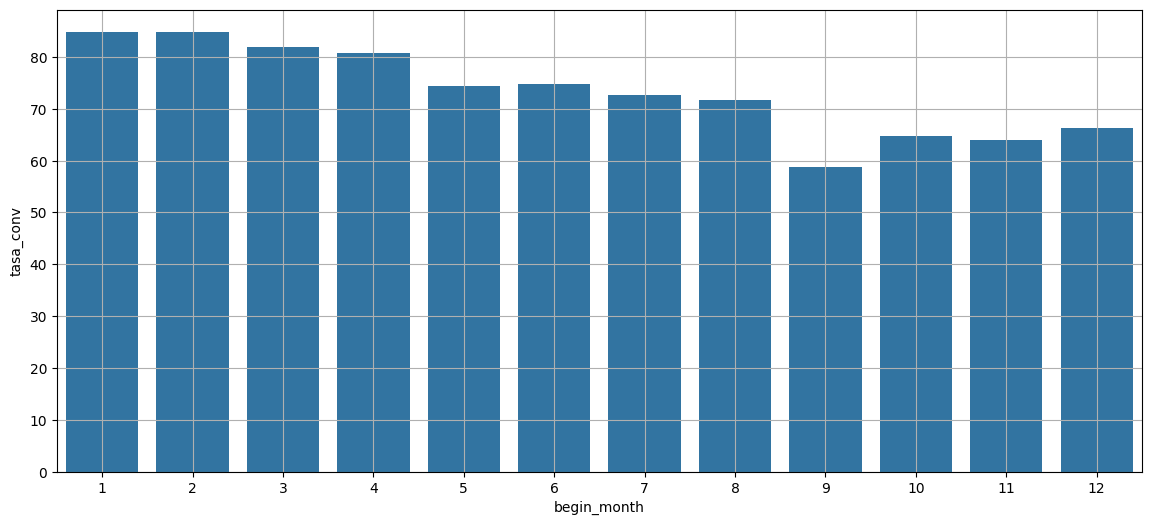

In [ ]:
#PASO 3: Graficar las tasas de conversión para la variable "begin_month"
graficar_tasas_conversion('begin_month','cancelled_bin', type="bar")

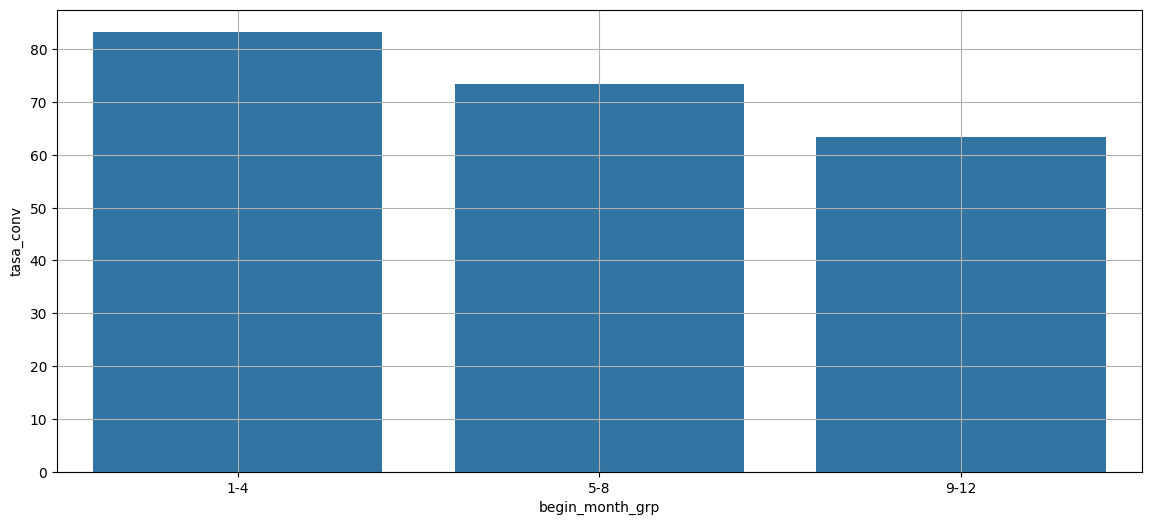

In [ ]:
#Generamos rangos en cuatrimestres
df_combined.loc[:,'begin_month_grp'] = "0"
df_combined.loc[(df_combined['begin_month']>=1) & (df_combined['begin_month']<=4),'begin_month_grp'] = "1-4"
df_combined.loc[(df_combined['begin_month']>=5) & (df_combined['begin_month']<=8),'begin_month_grp'] = "5-8"
df_combined.loc[(df_combined['begin_month']>=9) & (df_combined['begin_month']<=12),'begin_month_grp'] = "9-12"

#Grafiquemos la tasa de conversión para esta nueva columna
orden = [ "1-4", "5-8", "9-12"]
graficar_tasas_conversion('begin_month_grp','cancelled_bin',type='bar', order=orden)

#Eliminamos variable original "begin_month"
df_combined.drop('begin_month', axis=1, inplace=True)

In [ ]:
#Analizamos cantidades
df_combined["begin_month_grp"].value_counts().sort_index()

,count
begin_month_grp,
1-4,2528
5-8,2066
9-12,2449


In [ ]:
#Hacemos prueba chi
prueba_chi_cuadrado(df_combined, "begin_month_grp", "cancelled_bin")

Estadístico Chi-cuadrado: 254.58962435204032
Valor p: 5.206735269653383e-56
Grados de libertad: 2
Frecuencias esperadas:
 [[ 670.85503337 1857.14496663]
 [ 548.25415306 1517.74584694]
 [ 649.89081357 1799.10918643]]
Existe una asociación estadísticamente significativa entre begin_month_grp y cancelled_bin.


###### **Obs: begin_month_grp**

Aunque todos los meses cuentan con gran cantidad de clientes, el primer cuatrimestre es el que cuenta con mayor tasa, habrá que enfocarnos ahí. **begin_month_grp** es una **variable predictora**

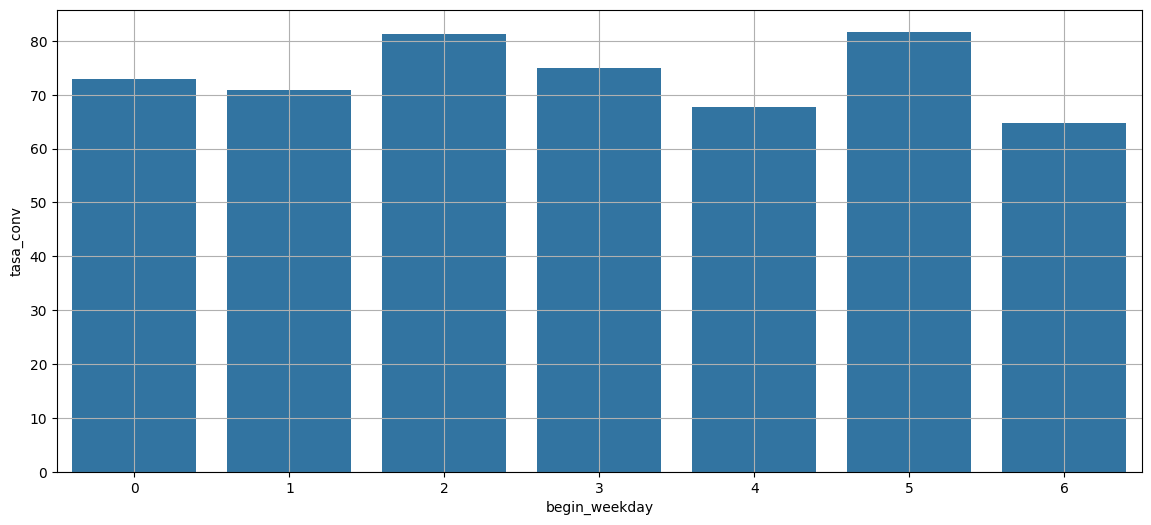

In [ ]:
#PASO 3: Graficar las tasas de conversión para la variable "begin_weekday"
graficar_tasas_conversion('begin_weekday','cancelled_bin', type="bar")

In [ ]:
#Analizamos cantidades
df_combined["begin_weekday"].value_counts().sort_index()

,count
begin_weekday,
0,847
1,948
2,963
3,873
4,1068
5,1225
6,1119


In [ ]:
#Hacemos prueba chi
prueba_chi_cuadrado(df_combined, "begin_weekday", "cancelled_bin")

Estadístico Chi-cuadrado: 139.81129401493558
Valor p: 1.0984524882108788e-27
Grados de libertad: 6
Frecuencias esperadas:
 [[224.76828056 622.23171944]
 [251.57063751 696.42936249]
 [255.55118557 707.44881443]
 [231.6678972  641.3321028 ]
 [283.41502201 784.58497799]
 [325.07809172 899.92190828]
 [296.94888542 822.05111458]]
Existe una asociación estadísticamente significativa entre begin_weekday y cancelled_bin.


###### **Obs: begin_weekday**

Muy parecido a los meses, todos cuentan con gran cantidad de clientes, pero los miércoles y sábados son cuando hay mayores tasas de cancelación. **begin_weekday** es una **variable predictora**

##### **Gráficos para variables categóricas**


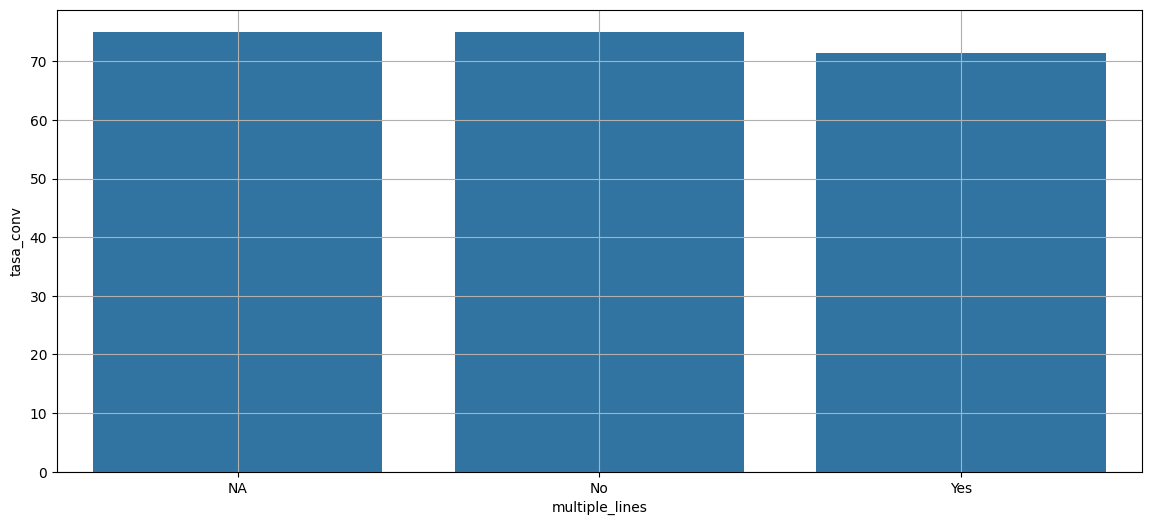

In [ ]:
#Para "multiple_lines"
graficar_tasas_conversion('multiple_lines','cancelled_bin',type='bar')

In [ ]:
 #Hacemos prueba chi
 prueba_chi_cuadrado(df_combined, "multiple_lines", "cancelled_bin")

Estadístico Chi-cuadrado: 11.330441483197559
Valor p: 0.0034643829548773038
Grados de libertad: 2
Frecuencias esperadas:
 [[ 180.98225188  501.01774812]
 [ 899.60386199 2490.39613801]
 [ 788.41388613 2182.58611387]]
Existe una asociación estadísticamente significativa entre multiple_lines y cancelled_bin.


###### **Obs: multiple_lines**

Aunque no se muestra gran diferencia entre tener o no múltiples líneas, ambas opciones cuentan con casi el 80% de probabilidad. Gracias a ese punto y la prueba chi-cuadrada, **multiple_lines es una variable predictora**

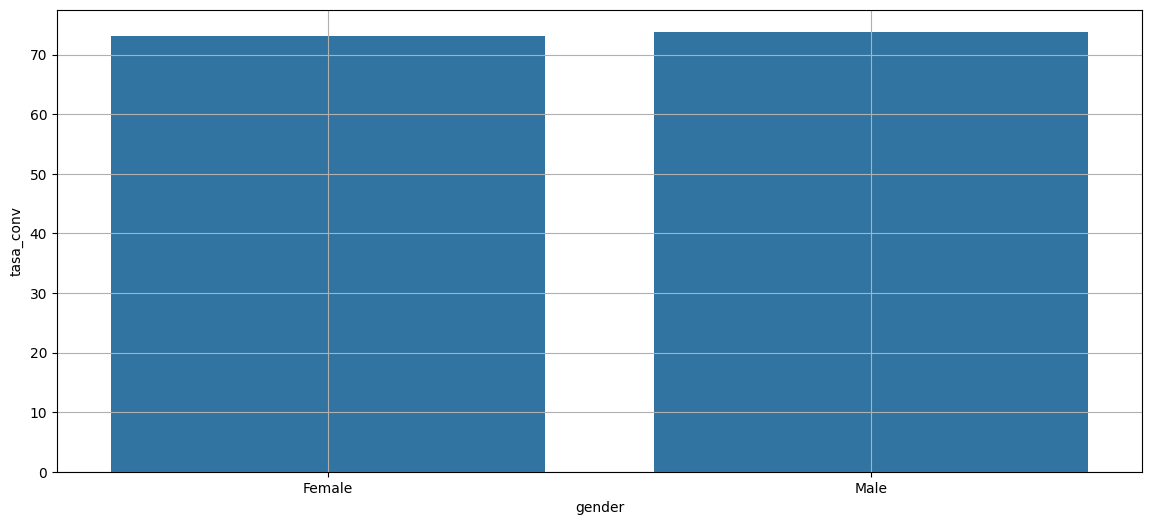

In [ ]:
#Para "gender"
graficar_tasas_conversion('gender','cancelled_bin',type='bar')

In [ ]:
 #Hacemos prueba chi
 prueba_chi_cuadrado(df_combined, "gender", "cancelled_bin")

Estadístico Chi-cuadrado: 0.4840828822091383
Valor p: 0.48657873605618596
Grados de libertad: 1
Frecuencias esperadas:
 [[ 925.61010933 2562.38989067]
 [ 943.38989067 2611.61010933]]
No existe una asociación estadísticamente significativa entre gender y cancelled_bin.


###### **Obs: gender**

Con tasas casi iguales y con un chi-cuadrado negativo, **gender NO** es una variable predictora

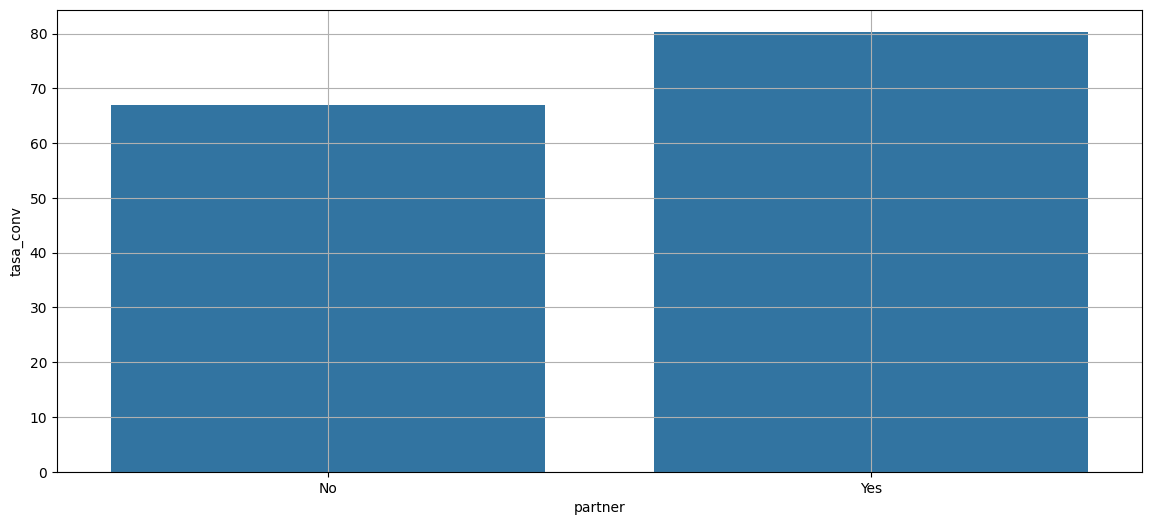

In [ ]:
#Para "partner"
graficar_tasas_conversion('partner','cancelled_bin',type='bar')

In [ ]:
 #Hacemos prueba chi
 prueba_chi_cuadrado(df_combined, "partner", "cancelled_bin")

Estadístico Chi-cuadrado: 158.7333820309922
Valor p: 2.1399113440759935e-36
Grados de libertad: 1
Frecuencias esperadas:
 [[ 966.21169956 2674.78830044]
 [ 902.78830044 2499.21169956]]
Existe una asociación estadísticamente significativa entre partner y cancelled_bin.


###### **Obs: partner**

Aunque no es muy grande la diferencia, hay más probabilidad de que los clientes con pareja cancelen.  
**partner es una variable predictora**

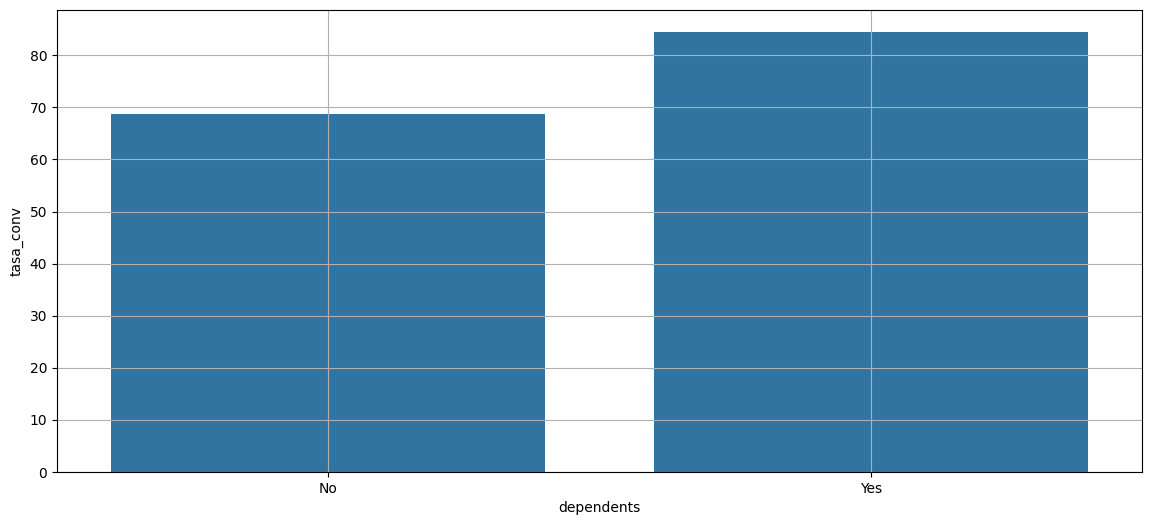

In [ ]:
#Para "dependents"
graficar_tasas_conversion('dependents','cancelled_bin',type='bar')

In [ ]:
 #Hacemos prueba chi
 prueba_chi_cuadrado(df_combined, "dependents", "cancelled_bin")

Estadístico Chi-cuadrado: 189.1292494042347
Valor p: 4.924921661215491e-43
Grados de libertad: 1
Frecuencias esperadas:
 [[1309.06957263 3623.93042737]
 [ 559.93042737 1550.06957263]]
Existe una asociación estadísticamente significativa entre dependents y cancelled_bin.


###### **Obs: dependents**

Al igual que "partner", al ser dependiente de alguien, se es mas probable a cancelar.   
 **dependents es una variable predictora**

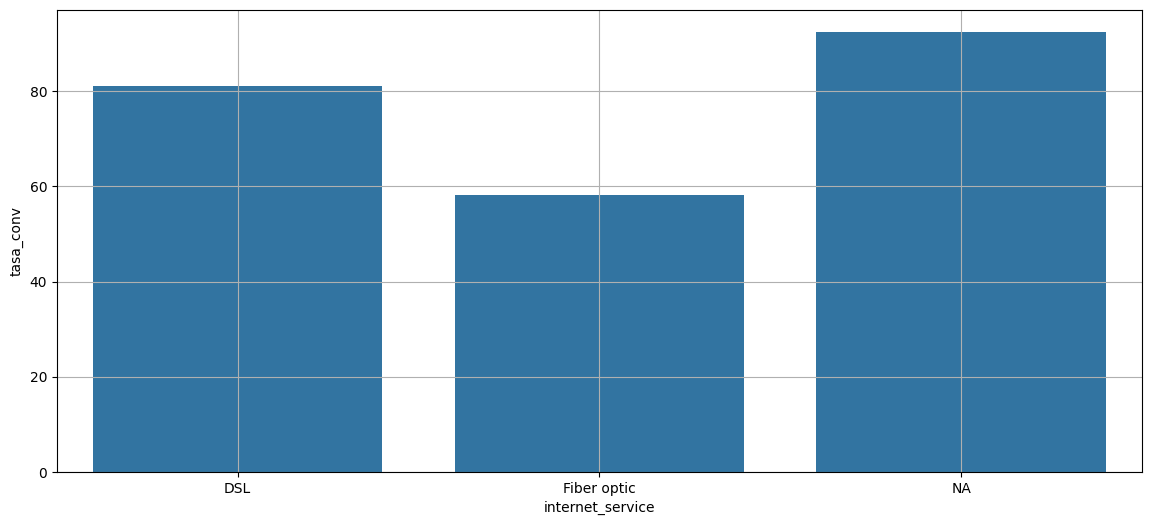

In [ ]:
#Para "internet_service"
graficar_tasas_conversion('internet_service','cancelled_bin',type='bar')

In [ ]:
 #Hacemos prueba chi
 prueba_chi_cuadrado(df_combined, "internet_service", "cancelled_bin")

Estadístico Chi-cuadrado: 732.309589667794
Valor p: 9.571788222840544e-160
Grados de libertad: 2
Frecuencias esperadas:
 [[ 642.46045719 1778.53954281]
 [ 821.58511998 2274.41488002]
 [ 404.95442283 1121.04557717]]
Existe una asociación estadísticamente significativa entre internet_service y cancelled_bin.


###### **Obs: internet_service**

Clientes con el servicio de DSL cuentan con más del 80% de tasa de conversión.   
 **internet_service es una variable predictora**

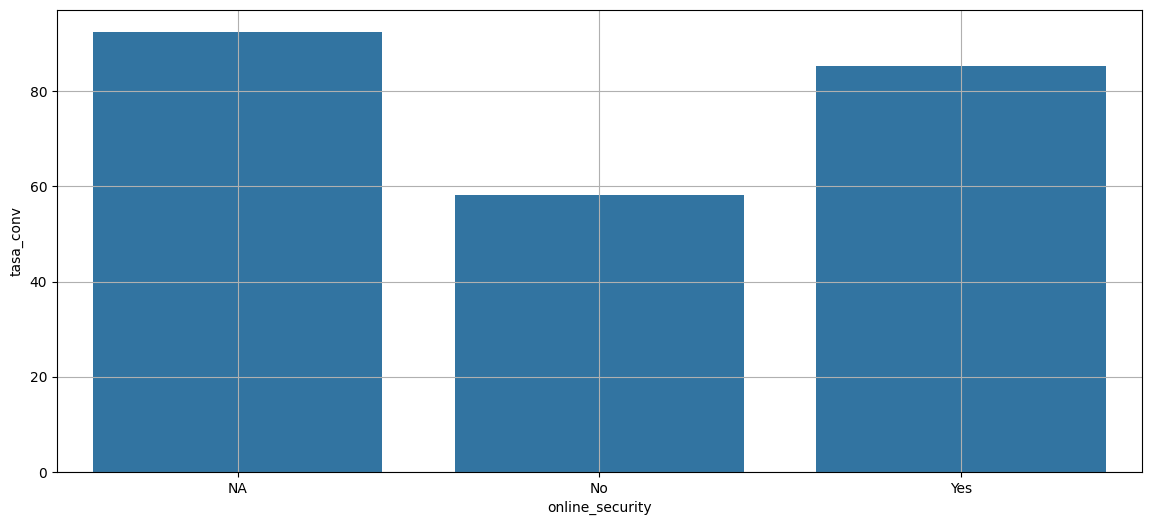

In [ ]:
#Para "online_security"
graficar_tasas_conversion('online_security','cancelled_bin',type='bar')

In [ ]:
 #Hacemos prueba chi
 prueba_chi_cuadrado(df_combined, "online_security", "cancelled_bin")

Estadístico Chi-cuadrado: 849.9989679615963
Valor p: 2.6611496351767036e-185
Grados de libertad: 2
Frecuencias esperadas:
 [[ 404.95442283 1121.04557717]
 [ 928.26380804 2569.73619196]
 [ 535.78176913 1483.21823087]]
Existe una asociación estadísticamente significativa entre online_security y cancelled_bin.


###### **Obs: online_security**

Con el 85% de tasa para los clientes con servicios de seguridad contratados, **online_security es una variable predictora**

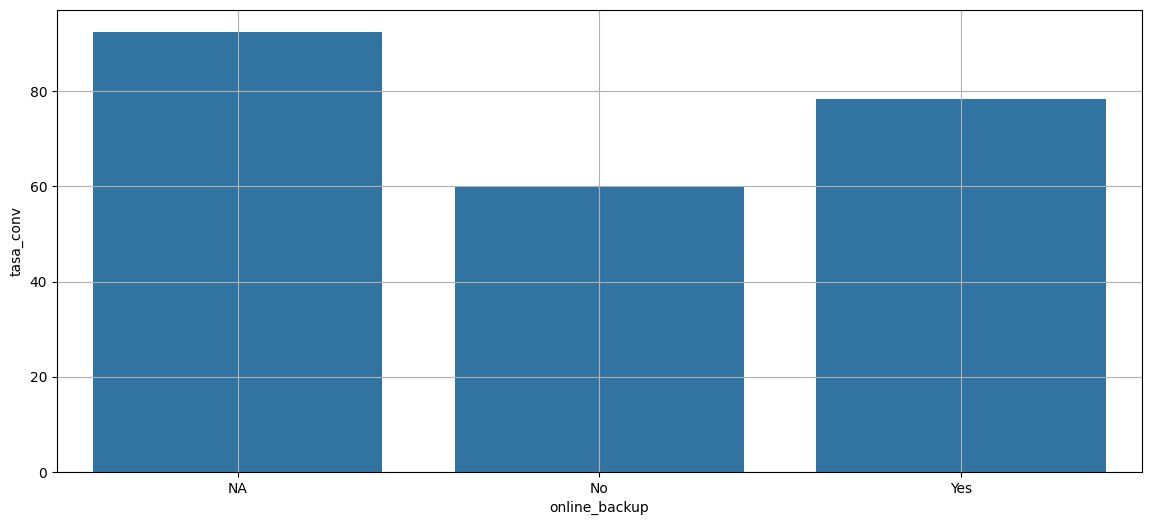

In [ ]:
#Para "online_backup"
graficar_tasas_conversion('online_backup','cancelled_bin',type='bar')

In [ ]:
 #Hacemos prueba chi
 prueba_chi_cuadrado(df_combined, "online_backup", "cancelled_bin")

Estadístico Chi-cuadrado: 601.812790113409
Valor p: 2.0797592160864276e-131
Grados de libertad: 2
Frecuencias esperadas:
 [[ 404.95442283 1121.04557717]
 [ 819.46216101 2268.53783899]
 [ 644.58341616 1784.41658384]]
Existe una asociación estadísticamente significativa entre online_backup y cancelled_bin.


###### **Obs: online_backup**

Aquellos que contratan copias de seguridad tienen una tasa de conversión del 80%, por lo tanto **online_backup es una variable predictora**

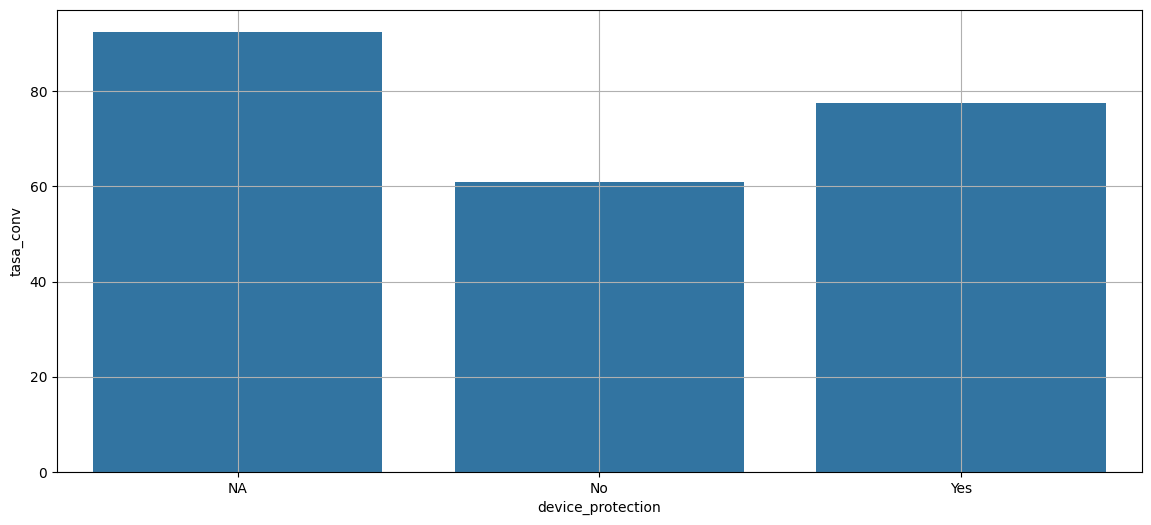

In [ ]:
#Para "device_protection"
graficar_tasas_conversion('device_protection','cancelled_bin',type='bar')

In [ ]:
 #Hacemos prueba chi
 prueba_chi_cuadrado(df_combined, "device_protection", "cancelled_bin")

Estadístico Chi-cuadrado: 558.419369407389
Valor p: 5.505219496457244e-122
Grados de libertad: 2
Frecuencias esperadas:
 [[ 404.95442283 1121.04557717]
 [ 821.31975011 2273.68024989]
 [ 642.72582706 1779.27417294]]
Existe una asociación estadísticamente significativa entre device_protection y cancelled_bin.


###### **Obs: device_protection**

Aquellos que contratan seguro a su equipo tienen una tasa de conversión del 80%, por lo tanto **device_protection es una variable predictora**

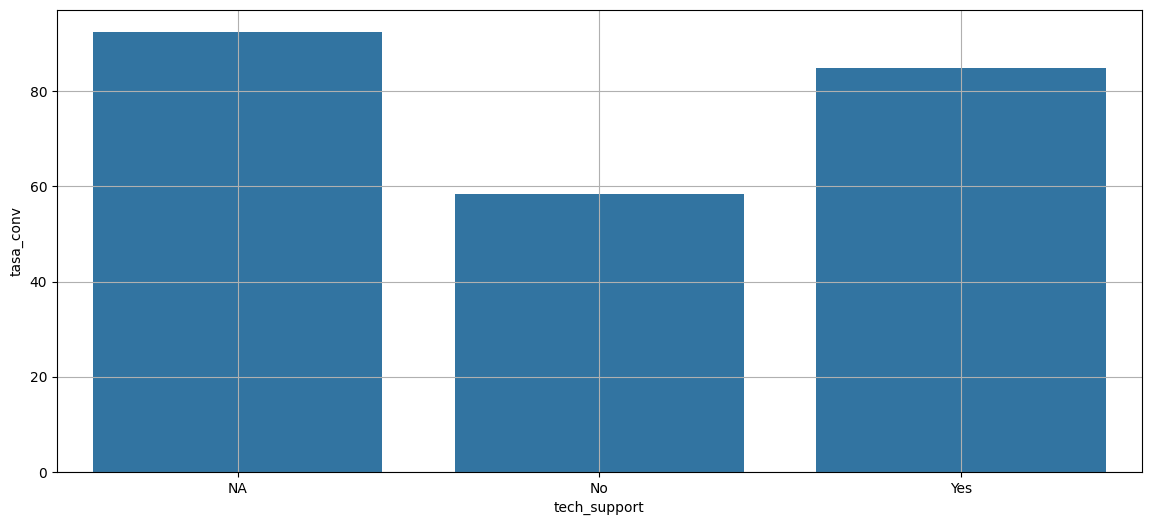

In [ ]:
#Para "tech_support"
graficar_tasas_conversion('tech_support','cancelled_bin',type='bar')

In [ ]:
 #Hacemos prueba chi
 prueba_chi_cuadrado(df_combined, "tech_support", "cancelled_bin")

Estadístico Chi-cuadrado: 828.1970684587393
Valor p: 1.4430840279999813e-180
Grados de libertad: 2
Frecuencias esperadas:
 [[ 404.95442283 1121.04557717]
 [ 921.62956127 2551.37043873]
 [ 542.4160159  1501.5839841 ]]
Existe una asociación estadísticamente significativa entre tech_support y cancelled_bin.


###### **Obs: tech_support**

Aquellos que contratan soporte técnico tienen una tasa de conversión del 80%, por lo tanto **tech_support es una variable predictora**

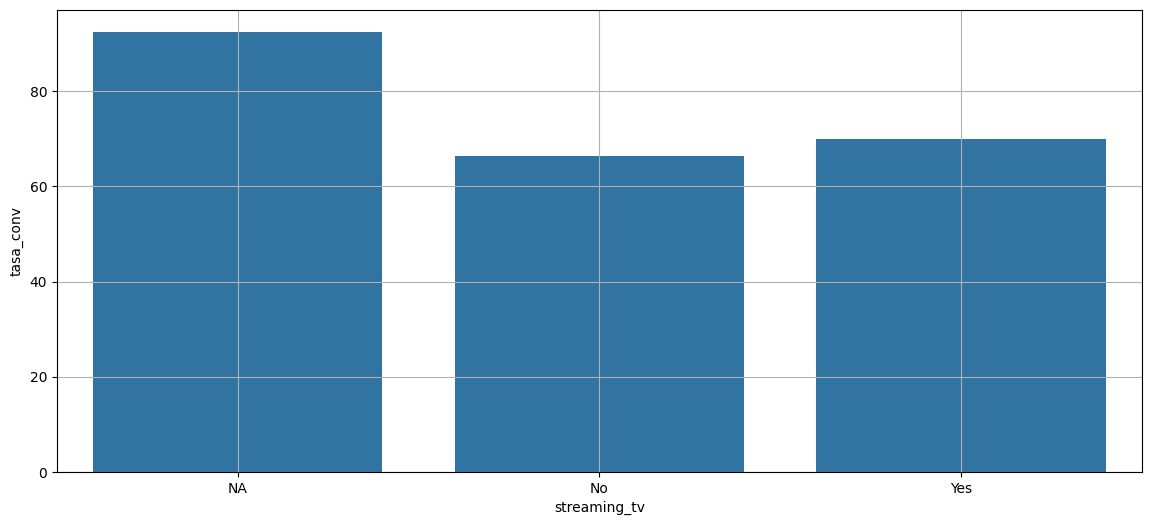

In [ ]:
#Para "streaming_tv"
graficar_tasas_conversion('streaming_tv','cancelled_bin',type='bar')

In [ ]:
 #Hacemos prueba chi
 prueba_chi_cuadrado(df_combined, "streaming_tv", "cancelled_bin")

Estadístico Chi-cuadrado: 374.20394331098134
Valor p: 5.528994485739024e-82
Grados de libertad: 2
Frecuencias esperadas:
 [[ 404.95442283 1121.04557717]
 [ 745.68933693 2064.31066307]
 [ 718.35624024 1988.64375976]]
Existe una asociación estadísticamente significativa entre streaming_tv y cancelled_bin.


###### **Obs: streaming_tv**

Conforma al streaming, no hay diferencia entre si se contrata o no, pero ambas cuentan con una tasa alta y la prueba chi-cuadrada dando positivo, hicimos de **streaming_tv** una **variable predictora**

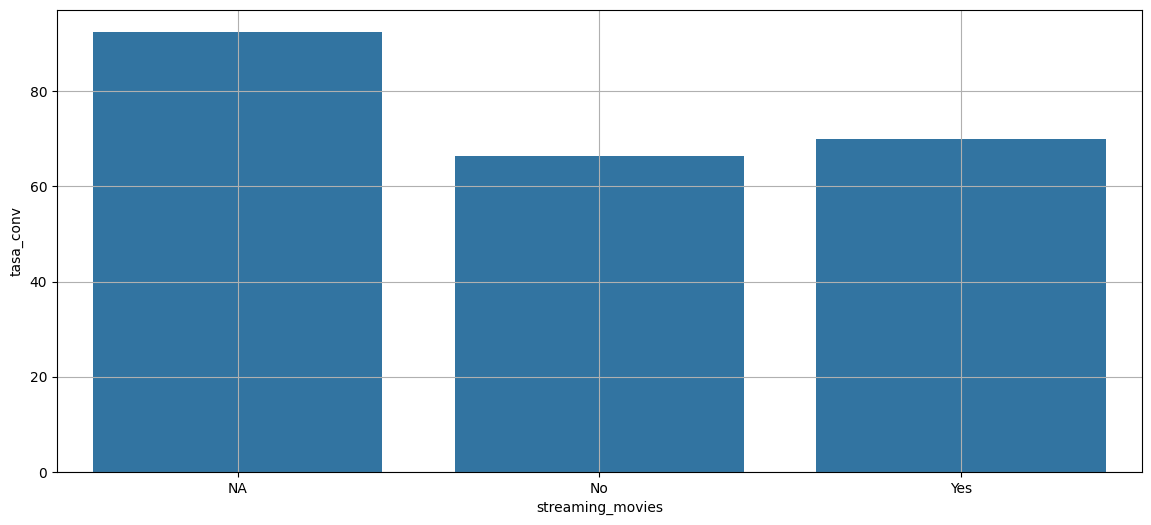

In [ ]:
#Para "streaming_movies"
graficar_tasas_conversion('streaming_movies','cancelled_bin',type='bar')

In [ ]:
 #Hacemos prueba chi
 prueba_chi_cuadrado(df_combined, "streaming_movies", "cancelled_bin")

Estadístico Chi-cuadrado: 375.66147934526555
Valor p: 2.667756755723757e-82
Grados de libertad: 2
Frecuencias esperadas:
 [[ 404.95442283 1121.04557717]
 [ 739.05509016 2045.94490984]
 [ 724.99048701 2007.00951299]]
Existe una asociación estadísticamente significativa entre streaming_movies y cancelled_bin.


###### **Obs: streaming_movies**

Al igual que con tv, streaming_movies no hay diferencia entre si se contrata o no, pero ambas cuentan con una tasa alta y la prueba chi-cuadrada dando positivo, hicimos de **streaming_movies** una **variable predictora**

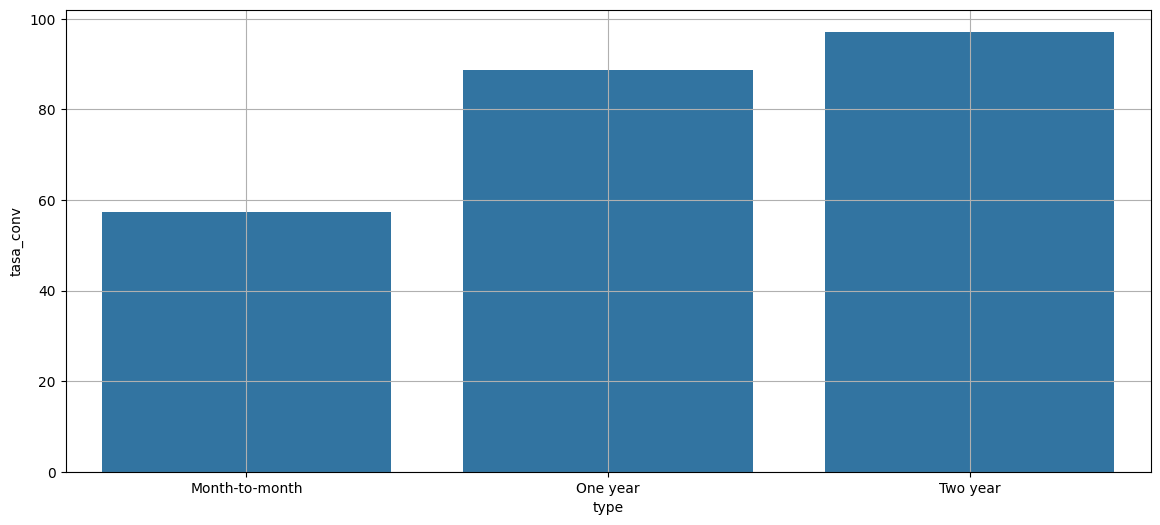

In [ ]:
#Para "type"
graficar_tasas_conversion('type','cancelled_bin',type='bar')

In [ ]:
#Analizamos cantidades de cada nivel
df_combined["type"].value_counts()

,count
type,
Month-to-month,3875
Two year,1695
One year,1473


In [ ]:
 #Hacemos prueba chi
 prueba_chi_cuadrado(df_combined, "type", "cancelled_bin")

Estadístico Chi-cuadrado: 1184.5965720837928
Valor p: 5.863038300672725e-258
Grados de libertad: 2
Frecuencias esperadas:
 [[1028.30824933 2846.69175067]
 [ 390.88981968 1082.11018032]
 [ 449.801931   1245.198069  ]]
Existe una asociación estadísticamente significativa entre type y cancelled_bin.


###### **Obs: type**

Para el tipo de pago, la tasa salio superior cuando un cliente contrata por un año o más el servicio, **type** es una **variable predictora**

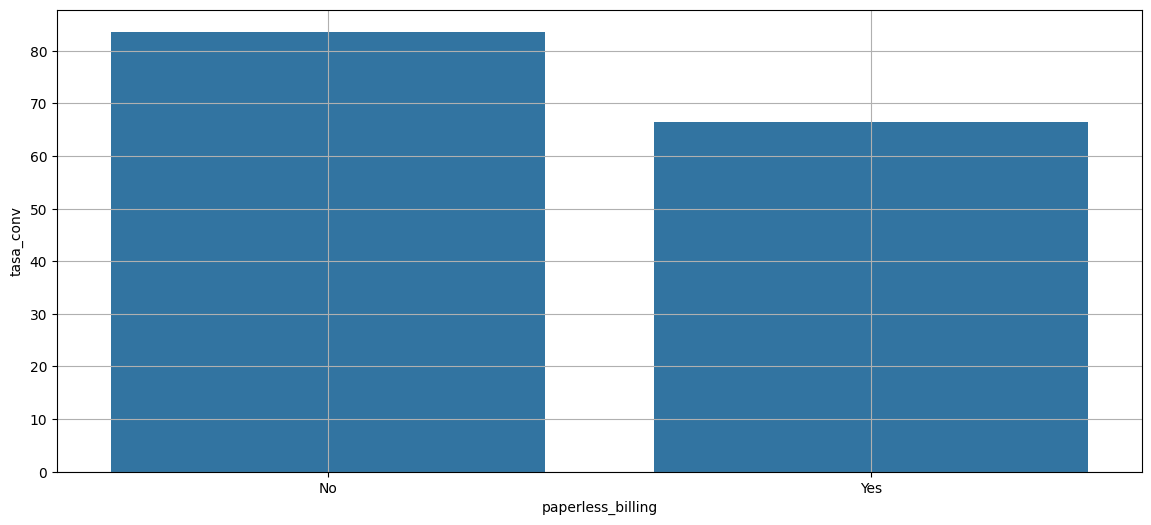

In [ ]:
#Para "paperless_billing"
graficar_tasas_conversion('paperless_billing','cancelled_bin',type='bar')

In [ ]:
 #Hacemos prueba chi
 prueba_chi_cuadrado(df_combined, "paperless_billing", "cancelled_bin")

Estadístico Chi-cuadrado: 258.27764906707307
Valor p: 4.073354668665985e-58
Grados de libertad: 1
Frecuencias esperadas:
 [[ 762.14226892 2109.85773108]
 [1106.85773108 3064.14226892]]
Existe una asociación estadísticamente significativa entre paperless_billing y cancelled_bin.


###### **Obs: paperless_billing**

Los clientes que no requieren factura física cuentan con más tasa sobre los que si quieren, **paperless_billing** es una **variable predictora**

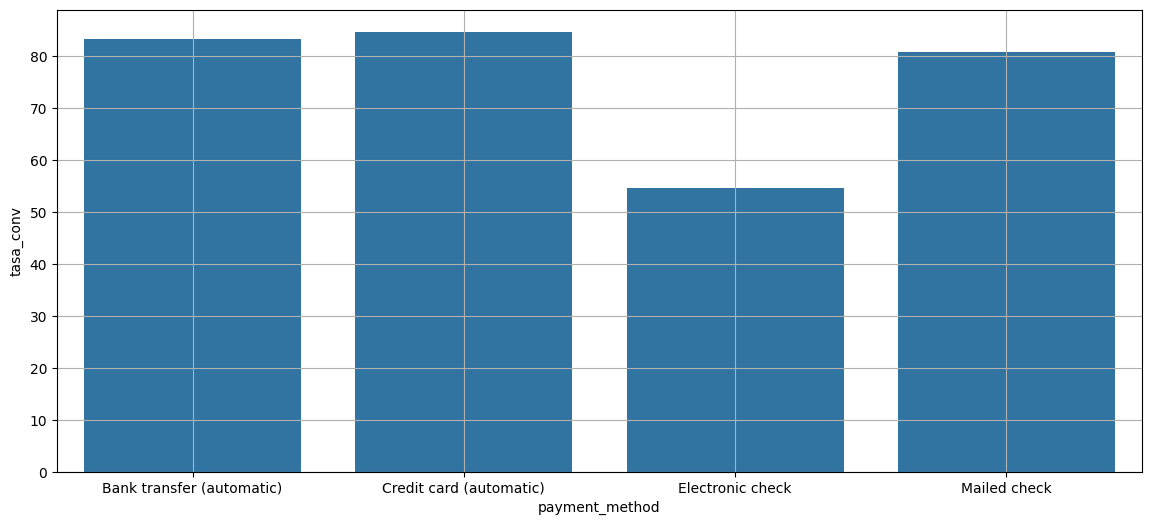

In [ ]:
#Para "payment_method"
graficar_tasas_conversion('payment_method','cancelled_bin',type='bar')

In [ ]:
 #Hacemos prueba chi
 prueba_chi_cuadrado(df_combined, "payment_method", "cancelled_bin")

Estadístico Chi-cuadrado: 648.1423274814
Valor p: 3.6823546520097993e-140
Grados de libertad: 3
Frecuencias esperadas:
 [[ 409.73108051 1134.26891949]
 [ 403.89294335 1118.10705665]
 [ 627.59974443 1737.40025557]
 [ 427.77623172 1184.22376828]]
Existe una asociación estadísticamente significativa entre payment_method y cancelled_bin.


###### **Obs: payment_method**

Para tres de los 4 tipos de forma de pago nos salen con una tasa de casi el 85%, **payment_method** es una **variable predictora**

##### **Resúmen**

Gracias a la tasa de conversión, pudimos ver que la **mayoría de nuestras variables son variables predictoras**, solamente **gender** fue la única variable que **no fue considerada.**

Se crearon nuevas variables gracias a que se hiceron rangos dentro de algunas variables y se eliminaron sus respectivas variables originales.


In [ ]:
#Eliminamos la variable "gender"
df_combined.drop('gender', axis=1, inplace=True)

##### **Elimino variables**
Elimino variables que no hacen relación con mi variable a predecir, aquellas que salieron de la variable end_date y otras columnas que se repiten o que ya son obsoletas

In [ ]:
#Eliminamos columnas
eliminar_col = ['customer_id',  'end_year', 'end_month', 'end_weekday', "duration_service"]
existentes_col = [col for col in eliminar_col if col in df_combined.columns]
df_combined.drop(columns=existentes_col, inplace=True)

---
#### **D-. Análisis bivariado: pares de variables Vs variable a predecir**

Analizar posibles interacciones entre pares de variables predictoras y su impacto en la variable a predecir.

Como existen muchas posibles combinaciones analizaremos únicamente los pares con mayor potencial.

Este análisis nos servirá para reforzar más el perfil del cliente que obtuvimos en el proceso pasado.
      

In [ ]:
#Tasa de conversión para dos columnas
def graficar_tc_bivariada(col_list, orden=None):
  tc = df_combined.groupby(col_list)['cancelled_bin'].mean().to_frame().reset_index()

  #Gráfica
  plt.figure(figsize=(13,7))
  ax = sns.pointplot(x=tc['cancelled_bin'], y=tc[col_list[0]], hue=tc[col_list[1]], join=False, order=orden)
  ax.yaxis.grid(True)
  ax.xaxis.grid(True)
  plt.title(f'Tasa de conversión para {col_list[0]} & {col_list[1]}')
  plt.xlabel('Tasa de conversión (%)')
  plt.xlim((0,1));

<ipython-input-856-ccd5a9fb5351>:7: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.pointplot(x=tc['cancelled_bin'], y=tc[col_list[0]], hue=tc[col_list[1]], join=False, order=orden)


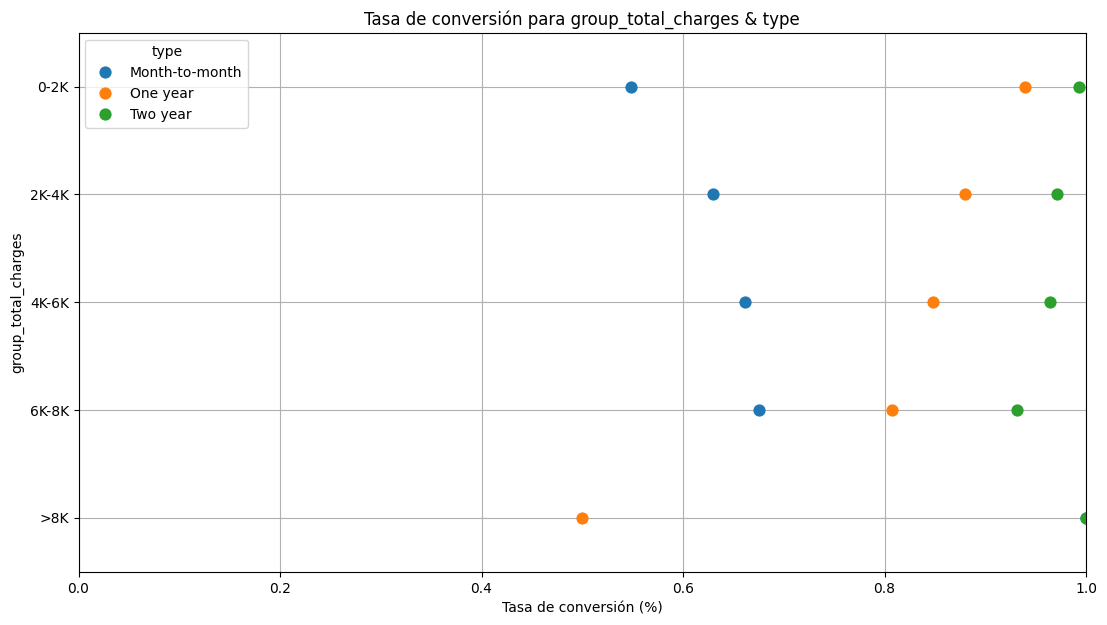

In [ ]:
#1. Par group_total_charges-type
graficar_tc_bivariada(['group_total_charges','type'])

<ipython-input-856-ccd5a9fb5351>:7: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.pointplot(x=tc['cancelled_bin'], y=tc[col_list[0]], hue=tc[col_list[1]], join=False, order=orden)


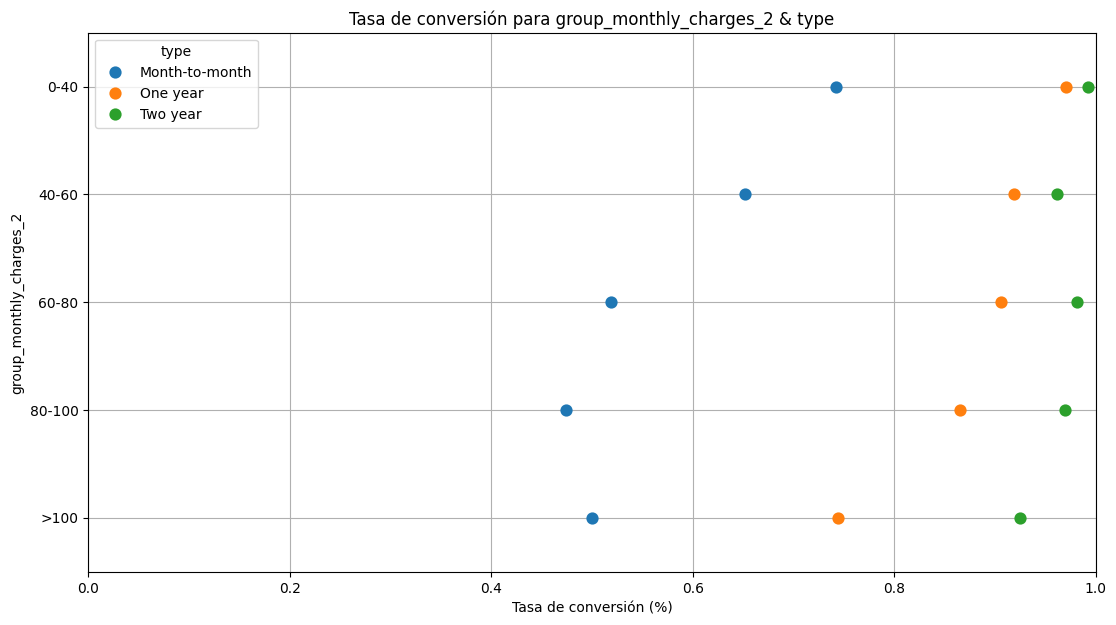

In [ ]:
#2. Par group_monthly_charges_2-type
graficar_tc_bivariada(['group_monthly_charges_2','type'])

<ipython-input-856-ccd5a9fb5351>:7: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.pointplot(x=tc['cancelled_bin'], y=tc[col_list[0]], hue=tc[col_list[1]], join=False, order=orden)


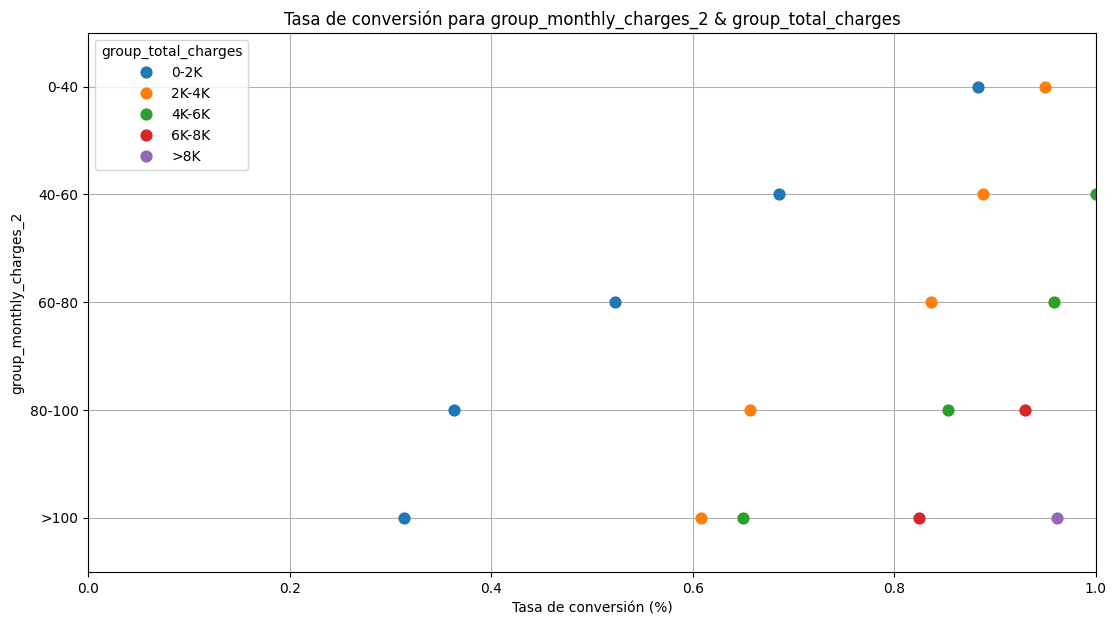

In [ ]:
#3. Par group_monthly_charges_2 - group_total_charges
graficar_tc_bivariada(['group_monthly_charges_2','group_total_charges'])

<ipython-input-856-ccd5a9fb5351>:7: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.pointplot(x=tc['cancelled_bin'], y=tc[col_list[0]], hue=tc[col_list[1]], join=False, order=orden)


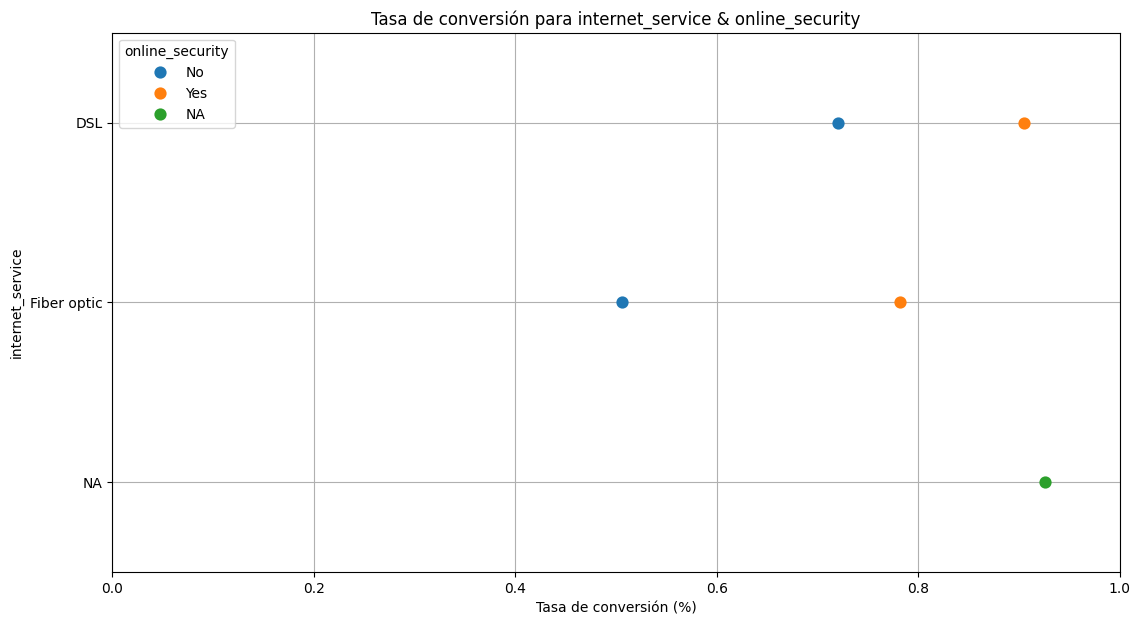

In [ ]:
#4. Par internet_service - online_security
graficar_tc_bivariada(['internet_service','online_security'])

<ipython-input-856-ccd5a9fb5351>:7: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.pointplot(x=tc['cancelled_bin'], y=tc[col_list[0]], hue=tc[col_list[1]], join=False, order=orden)


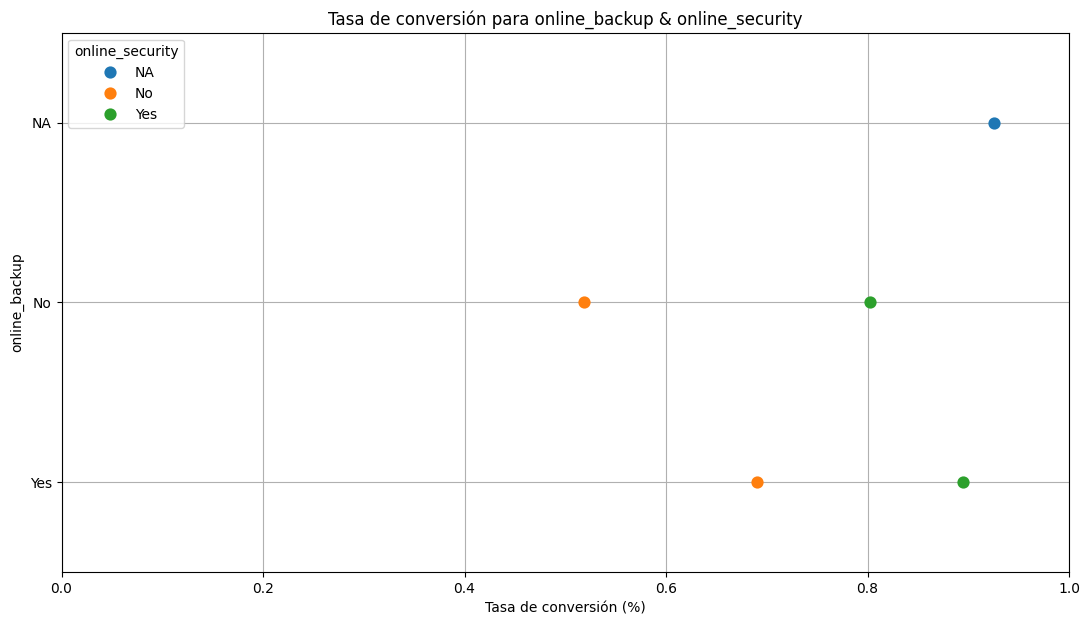

In [ ]:
#5. Par online_backup - online_security
graficar_tc_bivariada(['online_backup','online_security'])

<ipython-input-856-ccd5a9fb5351>:7: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.pointplot(x=tc['cancelled_bin'], y=tc[col_list[0]], hue=tc[col_list[1]], join=False, order=orden)


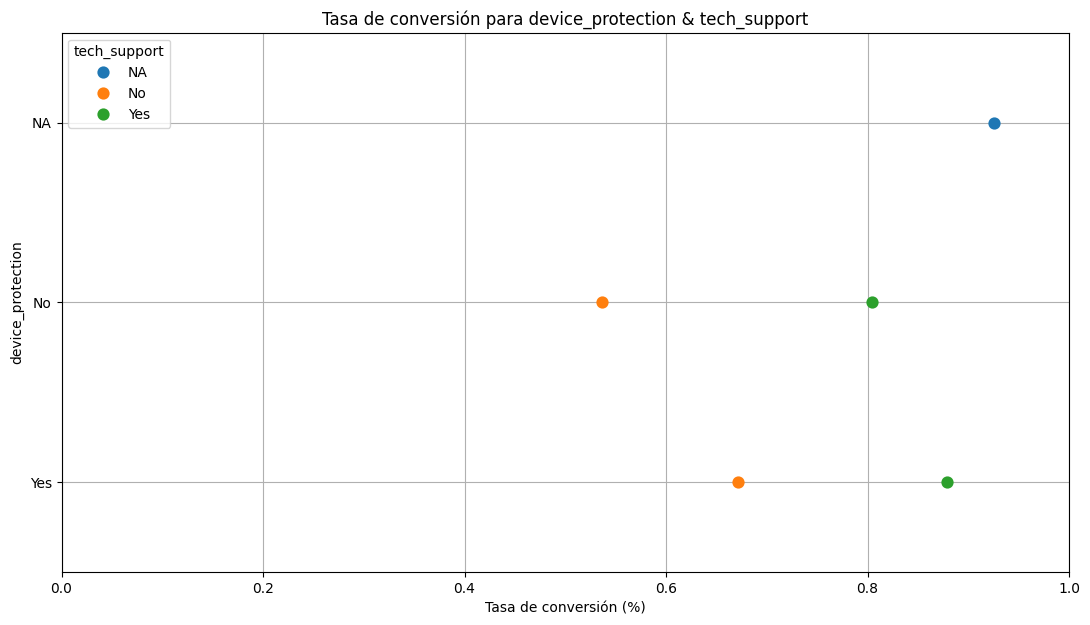

In [ ]:
#6. Par device_protection - tech_support
graficar_tc_bivariada(['device_protection','tech_support'])

##### **Resúmen**
En las primeras dos gráficas confirmamos sobre como un contrato de un año o más tiene una mayor tasa a comparación del pago mensual.

Para el tercer gráfico, mientras el pago total sea mayor y los pagos mensuales menor, hay una mayor tasa para ambos.

Y para las últimos gráficos confirmamos que entre más servicios contratados, mayor tasa de cancelación.

##### **Creación de nuevas variables**

In [ ]:
#Creamos nueva variable de group_total_charges sacando su raiz cuadrada para manejar valores atípicos
df_combined['sqrt_total_charges'] = np.sqrt(df_combined['total_charges'])

In [ ]:
#Codificamos con One-hot mis variables de "type", payment_method", "group_total_charges" para crear variables de interacción
columns_to_encode = ['type', 'payment_method', 'group_total_charges']
existing_columns = [col for col in columns_to_encode if col in df_combined.columns]

#Utilizamos pd.get_dummies en columnas
df_combined = pd.get_dummies(df_combined, columns=existing_columns)

In [ ]:
#Lista de columnas booleanas
bool_cols = [
    'type_Month-to-month',
    'type_One year',
    'type_Two year',
    'payment_method_Bank transfer (automatic)',
    'payment_method_Credit card (automatic)',
    'payment_method_Electronic check',
    'payment_method_Mailed check',
    'group_total_charges_0-2K',
    'group_total_charges_2K-4K',
    'group_total_charges_4K-6K',
    'group_total_charges_6K-8K',
    'group_total_charges_>8K',
]

#Convertir columnas booleanas a enteros
for col in bool_cols:
    df_combined[col] = df_combined[col].astype(int)


In [ ]:
#Interacción entre "Month-to-month" y "Electronic check"
df_combined['month_to_month_x_electronic_check'] = df_combined['type_Month-to-month'] * df_combined['payment_method_Electronic check']

#Interacción entre "One year" y "Mailed check"
df_combined['one_year_x_mailed_check'] = df_combined['type_One year'] * df_combined['payment_method_Mailed check']

#Interacción entre "Two year" y "Bank transfer (automatic)"
df_combined['two_year_x_bank_transfer'] = df_combined['type_Two year'] * df_combined['payment_method_Bank transfer (automatic)']

#Interacción entre "total charges 0-2k" y "Electronic check"
df_combined['0_2k_x_electronic_check'] = df_combined['group_total_charges_0-2K'] * df_combined['payment_method_Electronic check']

#Interacción entre "total charges 2k-4k" y "Credit card"
df_combined['2k_4k_x_credit_card'] = df_combined['group_total_charges_2K-4K'] * df_combined['payment_method_Credit card (automatic)']

In [ ]:
#Resumen de variables hasta el momento
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 37 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   multiple_lines                            7043 non-null   object 
 1   senior_citizen                            7043 non-null   int64  
 2   partner                                   7043 non-null   object 
 3   dependents                                7043 non-null   object 
 4   internet_service                          7043 non-null   object 
 5   online_security                           7043 non-null   object 
 6   online_backup                             7043 non-null   object 
 7   device_protection                         7043 non-null   object 
 8   tech_support                              7043 non-null   object 
 9   streaming_tv                              7043 non-null   object 
 10  streaming_movies                    

#### **E-. Conclusión**
Gracias a los análisis uni y bivariado pudimos sacar un **perfil de cliente a considerar**.

Hay que tener en cuenta a cualquier persona que no sea adulto mayor, en pareja, cargos mensuales entre 60 a 95 dólares y cargos totales entre 0 y 2100 dólares.

Aquellas personas que contrataron servicios como: internet, múltiples líneas, soporte, etc, (no incluye streaming) por el año completo o más, personas que pagan con métodos automáticos o mail y que no necesitan facturas físicas.

Por último, empezar a presetar mucha más atención en aquellos clientes que pasen del año y medio con el servicio, ya que la media de duración de un servicio fue de 1.5 años

Los clientes que cuenten con este perfil tendrán un 80% o más de probabilidad de cancelar, por lo que ellos serían los ideales a un código promocional para que sigan con los servicios y con la empresa.

---
### **3. División de datos**  

#### **Pasos:**
  - A. Dividir datos en entrenamiento, validación y prueba (60-20-20)
  - B. Dependiendo si es necesario, codificar y escalar columnas (posiblemente eliminar columnas que no me ayuden)
  - C. Hacer sub o sobre muestreo si es necesario en mi variable a predecir para un buen balanceo
  - D. Observaciones

#### **A.- Dividir datos en entrenamiento, validación y prueba (60-20-20)**

In [ ]:
#Dividimos mi objetivo y mis características, luego dividimos datos 60 / 20 / 20
target = df_combined['cancelled_bin']
features = [
    'multiple_lines',
    'partner',
    'dependents',
    'internet_service',
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies',
    'paperless_billing',
    'group_monthly_charges_2',
    'begin_year_grp',
    'begin_month_grp',
    'senior_citizen',
    'begin_weekday',
    'total_charges',
    'sqrt_total_charges',
    'monthly_charges'
]
features_OHot = [
    'type_Month-to-month',
    'type_One year',
    'type_Two year',
    'payment_method_Bank transfer (automatic)',
    'payment_method_Credit card (automatic)',
    'payment_method_Electronic check',
    'payment_method_Mailed check',
    'group_total_charges_0-2K',
    'group_total_charges_2K-4K',
    'group_total_charges_4K-6K',
    'group_total_charges_6K-8K',
    'group_total_charges_>8K',
    'month_to_month_x_electronic_check',
    'one_year_x_mailed_check',
    'two_year_x_bank_transfer',
    '0_2k_x_electronic_check',
    '2k_4k_x_credit_card'
]

#Dividimos mis datos (features) en tres: entrenamiento 60%, validación 20% y prueba 20%
X_train, X_temp, target_train, target_temp = train_test_split(df_combined, target, test_size=0.4, random_state=42)
X_valid, X_test, target_valid, target_test = train_test_split(X_temp, target_temp, test_size=.5, random_state=42)


In [ ]:
print(X_train.shape, target_train.shape)
print(X_valid.shape, target_valid.shape)
print(X_test.shape, target_test.shape)

(4225, 37) (4225,)
(1409, 37) (1409,)
(1409, 37) (1409,)


In [ ]:
#Separar features y features_Ohot para entrenamiento
features_train = X_train[features]
features_train_OHot = X_train[features_OHot]

#Separar features y features_Ohot para validación
features_valid = X_valid[features]
features_valid_OHot = X_valid[features_OHot]

#Separar features y features_Ohot para prueba
features_test = X_test[features]
features_test_OHot = X_test[features_OHot]

#### **B.- Codificar y escalar columnas si es necesario ***

In [ ]:
#Identificar columnas categóricas y numéricas
categorical_cols = features_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = ['senior_citizen',  'begin_weekday', 'total_charges', 'monthly_charges', 'sqrt_total_charges']

#Codificar las variables categóricas
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
features_train_cat_enc = encoder.fit_transform(features_train[categorical_cols])
features_valid_cat_enc = encoder.transform(features_valid[categorical_cols])
features_test_cat_enc = encoder.transform(features_test[categorical_cols])

#Escalar las variables numéricas
scaler = StandardScaler()
features_train_num_scaled = scaler.fit_transform(features_train[numerical_cols])
features_valid_num_scaled = scaler.transform(features_valid[numerical_cols])
features_test_num_scaled = scaler.transform(features_test[numerical_cols])

#Concatenar los DataFrames
new_features_train = np.concatenate([features_train_num_scaled, features_train_cat_enc, features_train_OHot], axis=1)
new_features_valid = np.concatenate([features_valid_num_scaled, features_valid_cat_enc, features_valid_OHot], axis=1)
new_features_test = np.concatenate([features_test_num_scaled, features_test_cat_enc, features_test_OHot], axis=1)
print(new_features_train.shape)
print(new_features_valid.shape)
print(new_features_test.shape)

(4225, 65)
(1409, 65)
(1409, 65)


#### **C.- Hacer sub o sobre muestreo si es necesario en mi variable a predecir para un buen balanceo**

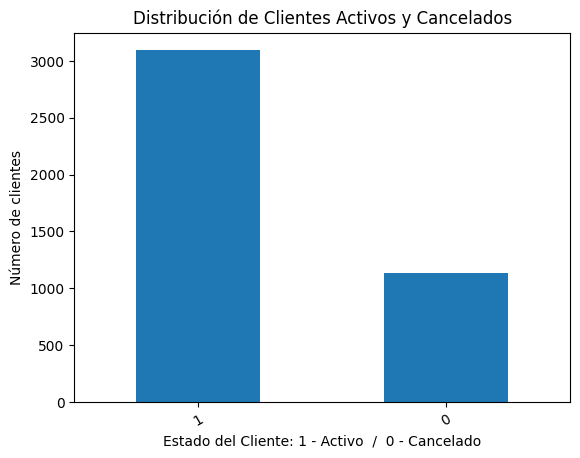

cancelled_bin
1    0.732071
0    0.267929
Name: proportion, dtype: float64


In [ ]:
#Analizamos si existe desbalance de clases
target_train.value_counts().plot.bar(rot=30)
plt.title('Distribución de Clientes Activos y Cancelados')
plt.xlabel('Estado del Cliente: 1 - Activo  /  0 - Cancelado')
plt.ylabel('Número de clientes')
plt.show()

#Sacamos porcentaje de cada clase
print(target_train.value_counts(normalize=True))

In [ ]:
#Realizamos balanceo de clases con SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
new_features_train, target_train = sm.fit_resample(new_features_train, target_train)


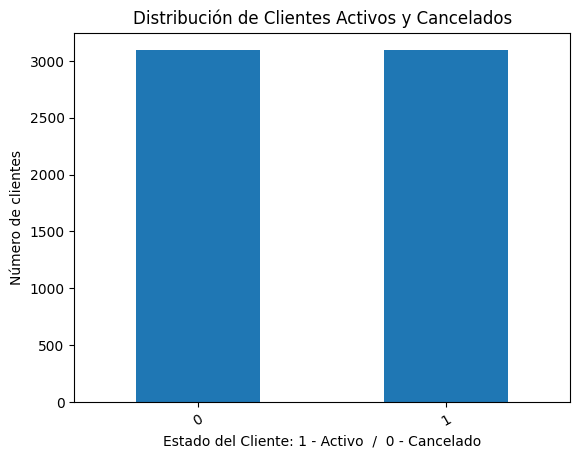

cancelled_bin
0    0.5
1    0.5
Name: proportion, dtype: float64


In [ ]:
#Verificamos que se haya hecho el balanceo
target_train.value_counts().plot.bar(rot=30)
plt.title('Distribución de Clientes Activos y Cancelados')
plt.xlabel('Estado del Cliente: 1 - Activo  /  0 - Cancelado')
plt.ylabel('Número de clientes')
plt.show()

#Sacamos porcentaje de cada clase
print(target_train.value_counts(normalize=True))


#### **D.- Observaciones**

Al verificar que ya tenemos un buen balance y se codifico lo necesario, podemos seguir con el ejercicio de entrenar diferentes modelos.

---
### **4. Crear modelos de clasificación binaria**

#### **Pasos:**

  - A. Modelos de clasificación binaria: Árbol de decisión, Bosque aleatorio, Regresión logística, Descenso del gradiente.
  - B. Hacer prueba final con todos los modelos, comparar y ver el mejor modelo
  - C. Sacar métricas y gráficos de F1 y AUC-ROC mayor a .75

In [ ]:
#Creamos función para evaluar un modelo con sus respectivos graficos y métricas
def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

#### **A, B y C.- Modelos de clasificación binaria, hacer prueba y sacar métricas**

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


          train  test
Accuracy   0.83  0.80
F1         0.83  0.85
APS        0.91  0.94
ROC AUC    0.91  0.87


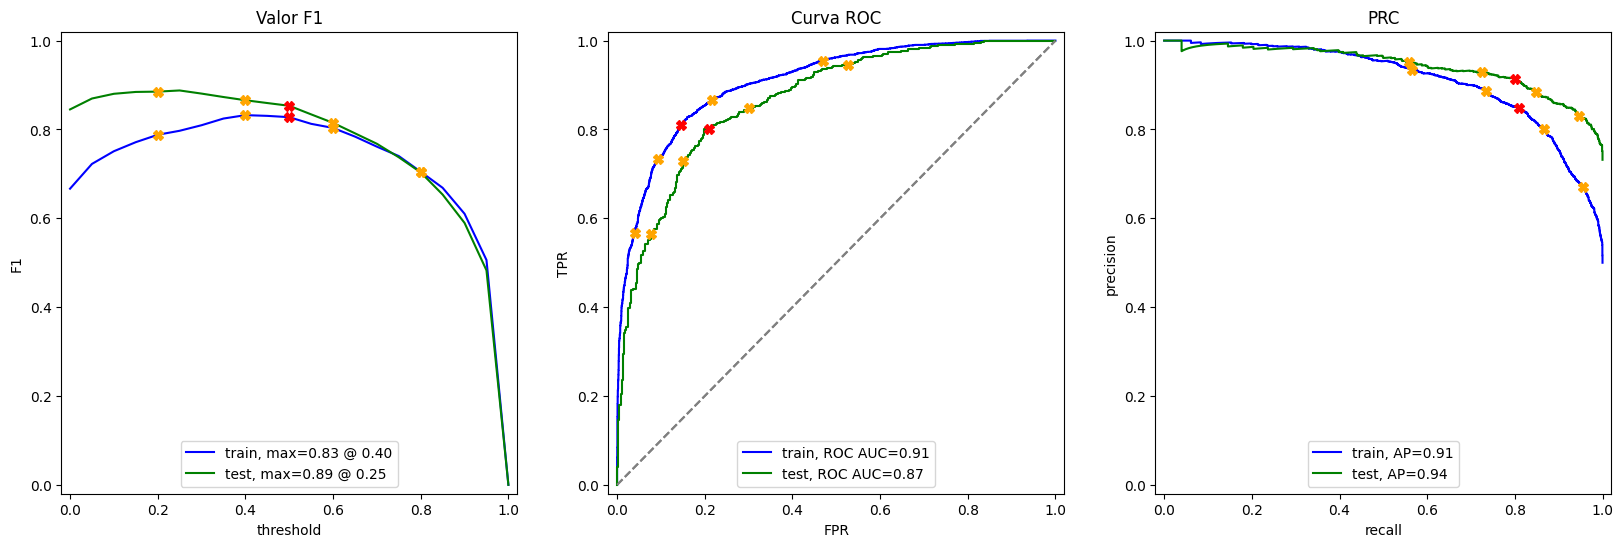

In [ ]:
#Entrenar el modelo de REGRESIÓN LOGÍSTICA con mejores hiperparámetros
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300]
}

#Crear una instancia de GridSearchCV
grid_search_lr = GridSearchCV(LogisticRegression(random_state=42), param_grid_lr, cv=5, scoring='f1', n_jobs=-1)

#Ajustar GridSearchCV a los datos de entrenamiento
grid_search_lr.fit(new_features_train, target_train)

#Obtener los mejores hiperparámetros y el mejor modelo
best_params_1 = grid_search_lr.best_params_
best_model_1 = grid_search_lr.best_estimator_

#Utilizar el mejor modelo en la función evaluate_model
evaluate_model(best_model_1, new_features_train, target_train, new_features_test, target_test)

          train  test
Accuracy   0.91  0.77
F1         0.91  0.84
APS        0.98  0.89
ROC AUC    0.98  0.80


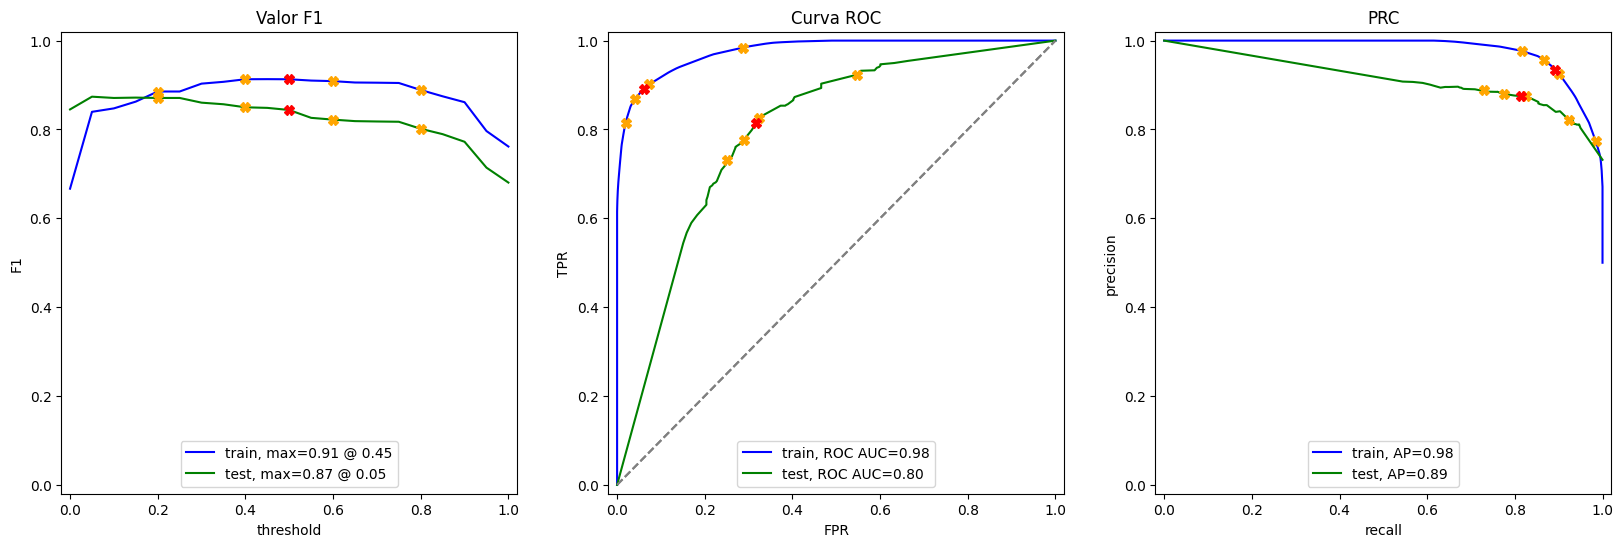

In [ ]:
#Entrenar el modelo de DECISION TREE con mejores hiperparámetros
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

#Crear una instancia de DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)

#Crear GridSearchCV para Decision Tree
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='f1', n_jobs=-1)

#Ajustar GridSearchCV a los datos de entrenamiento
grid_search_dt.fit(new_features_train, target_train)

#Obtener los mejores hiperparámetros y el mejor modelo
best_params_dt = grid_search_dt.best_params_
best_dt = grid_search_dt.best_estimator_

#Utilizar el mejor modelo para evaluar
evaluate_model(best_dt, new_features_train, target_train, new_features_test, target_test)

          train  test
Accuracy    1.0  0.83
F1          1.0  0.88
APS         1.0  0.93
ROC AUC     1.0  0.85


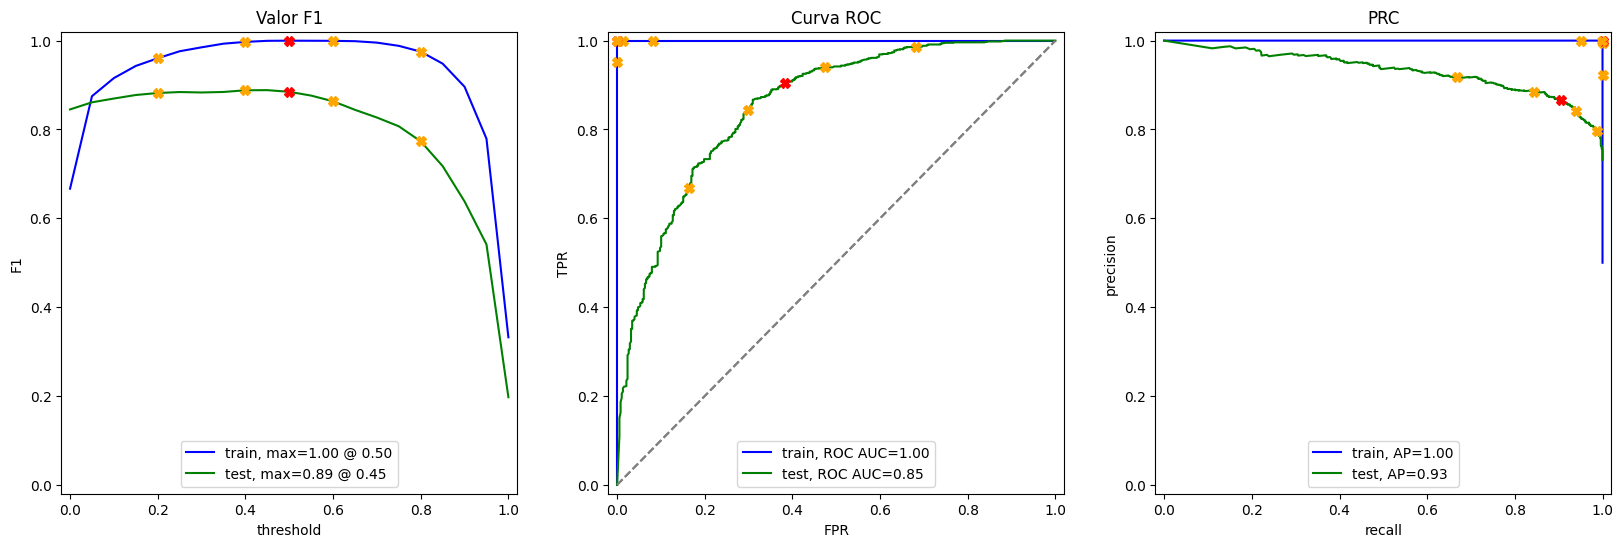

In [ ]:
#Definir los hiperparámetros para RANDOM FOREST
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

#Crear una instancia de RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

#Crear GridSearchCV para Random Forest
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='f1', n_jobs=-1)

#Ajustar GridSearchCV a los datos de entrenamiento
grid_search_rf.fit(new_features_train, target_train)

#Obtener los mejores hiperparámetros y el mejor modelo
best_params_rf = grid_search_rf.best_params_
best_rf = grid_search_rf.best_estimator_

#Utilizar el mejor modelo para evaluar
evaluate_model(best_rf, new_features_train, target_train, new_features_test, target_test)

Mejores hiperparámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1}
          train  test
Accuracy   0.97  0.85
F1         0.97  0.90
APS        1.00  0.94
ROC AUC    1.00  0.88


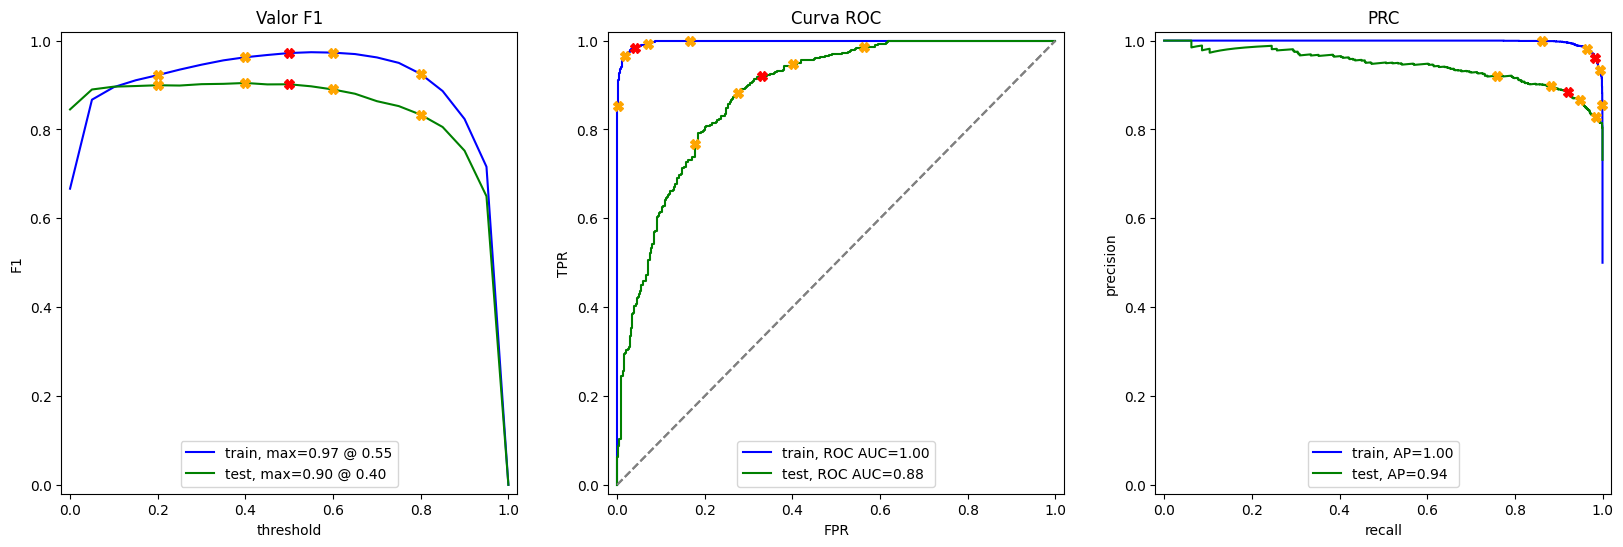

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report
# Definir los hiperparámetros PARA XGBOOST
param_grid = {
    'n_estimators': [100, 200, 250],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1]
}

#Crear una instancia de XGBClassifier
xgb_model = xgb.XGBClassifier(random_state=42)

#Crear una instancia de GridSearchCV
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

#Ajustar GridSearchCV a los datos de entrenamiento
grid_search.fit(new_features_train, target_train)

#Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

#Obtener el mejor modelo
best_xgb = grid_search.best_estimator_

#Evaluar el mejor modelo en el conjunto de prueba
y_pred = best_xgb.predict(new_features_test)
y_prob = best_xgb.predict_proba(new_features_test)[:, 1]

#Utilizar el mejor modelo para evaluar
evaluate_model(best_xgb, new_features_train, target_train, new_features_test, target_test)

### **5. Conclusiones:**

### **Sobre el modelo:**
Al entrenar los diferentes modelos, pudimos ver que el descenso de gradiente de XGboost fue la mejor opción, obtuviendo un **ROC** de .88 y una **Precisión** de .83, cabe destacar que la regresión logística no se quedaba nada atrás.

Características como el aprendizaje de los árboles anteriores, regularización, manejo de valores perdidos y su flexibilidad ante problemas de clasificación y regresión hicieron de XGBoost nuestra modelo a elegir.



### **Sobre el perfil:**

Ya escrito anteriormente, se debería enfocar o prestar más atención al siguiente perfil:   

 - Con pareja   
 - Adulto NO mayor   
 - No necesitan facturas físicas   
 - Pagos con métodos automáticos o mail    
 - Cargos mensuales entre 60 a 95 dólares   
 - Cargos totales entre 0 y 2100 dólares   
 - Servicios contratados como: internet, múltiples líneas, soporte, backup.
 - La gente solía cancelar en los meses de Oct y Nov entre miércoles y jueves.
 - Por último, tener más atencion en los clientes que pasan el año y medio de servicio con este perfil ya que indica que son bastante propensos a cancelar.

Los clientes que cuenten con este perfil tendrán un 80% o más de probabilidad de cancelar, por lo que ellos serían los ideales a un código promocional para que sigan con los servicios y con la empresa.

### **Informe de solución:**

---
**¿Qué pasos del plan se realizaron y qué pasos se omitieron? **
**A. Creación de variables**
 - Creación de variables para un mejor rendimiento en el modelo:  
  - Se agregaron variables como **"sqrt_total_charges"** (raíz cuadrada para manejar mejor los outliers), variables de interacción donde se multiplicaban variables entre si, ejemplo: **tipo de pago x cargo mensual** entre otras.
 - Creación de variables con base en la variable a predecir:
  - Saque la variable de **"duration_service"** donde pude evaluar por cuantos días se contrataron los servicios.
  - Variables de **"end_date"** donde pude ver mes y día de la semana más frecuentes donde una persona solía cancelar"

**B. Codificación**
 - Se agrego un paso de codificación para algunas variables y así poder crear las variables de interacción.

**C. Observaciones**
  - Se generaron más puntos donde se analizaban los pasos o se daba alguna observación de lo que se encontraba. La idea era desmenuzar una **observación final** en muchas.

**D. Eliminación de variables**
 - Para tener un código más limpio, tuve que eliminar variables mientras iba avanzando en el proceso. Anteriormente tenía un paso al final para eliminar las variables pero resultaba un tanto complicado y confuso recordar cuales se tenían que borrar o eliminar.

**E. Pasos de: "Crear modelos" y "Hacer prueba final"**
 - Se fusionaron mis pasos de "crear modelos" y "hacer prueba final" ya que por cada modelo que se creaba, el resultado final tambíen se hacía. Por lo que en teoría se elimino un paso.
 -También ya no se experimento con redes neuronales o series de tiempo, se considero que con los modelos de random forest, regresión logística, árbol de decisión y XGBoost era suficiente.



---
**¿Qué dificultades encontraste y cómo lograste resolverlas?**   
 **Para elevar el rendimiento de mi modelo se hizo lo siguiente:**
  - Primero, se encontró que estaba **dando información al modelo** con la variable a predecir, o sea, en lugar de borrar las "sub" variables que saque de **"end_date"**, las estaba utilizando para entrenar al modelo.
  - Segundo, cree **nuevas variables** para que se pudieran entrenar mejor los modelos.    
  
**Conforme a lectura de gráficos:**   
 - Para poder leer gráficos en los análisis bivariados fue necesario pasar por diferentes tipos para poder encontrar el mejor

---
**¿Cuáles fueron algunos de los pasos clave para resolver la tarea?**   
 **Creación de variables:**
  - Como primero experimente sin necesidad de crear variables y vi que los resultados no eran satisfactorios, decidi jugar con las variables. Primero se creaon variables con los rangos que le saque a las variables principales, luego las variables de interacción y luego la raíz cuadrada.
  
**Entender muy bien los datos:**   
 - Me di cuenta que no había comprendido al 100 los datos ya que le estaba dando información al modelo, es por eso que empezar nuevamente e incluso desde un paso más atrás para ver bien el panorma, ayudo a que analizara mejor los datos.
 - Cuando uní los diferentes data frames tarde en darme cuenta que la mejor solución era el parámetro **"outer"** para mi función **merge()**, esto significaba que si los clientes estaban dentro del data frame con más valores, era por que habían contratado algun servicio pero otros no.

---
**Modelo final y su calidad**   
 **XGBoost**
  - El mejor modelo fue XGBoost.   
  Como comento en las conclusiones creo que ayudo mucho que XGBoost corrige errores de árboles pasados y la regularización para prevenir el sobre ajuste.
  Terminamos con un **área bajo la curva de .88 y una precisión de .83**
  -En terminos generales tiene un buen nivel ya que cumple con los criterios que se pedían **(AUC-ROC ≥ 0.88)**
  
